In [ ]:
!pip install lexicalrichness
!pip install textstat
!pip install plotly==4.11.0
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords    
stop_words = set(stopwords.words('english'))

%matplotlib inline
from matplotlib import pyplot as plt

import pandas as pd
import numpy as np
import seaborn as sns
from nltk.tag import pos_tag
from nltk import word_tokenize
from collections import Counter

import textstat
from lexicalrichness import LexicalRichness

import plotly.express as px
import plotly.offline as pyo
import plotly.figure_factory as ff
import plotly.graph_objects as go
# pyo.init_notebook_mode()
# from plotly.offline import iplot as pyo


from collections import Counter
import pickle
from nltk.stem.porter import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegressionCV
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support
import re
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score, GridSearchCV

  Created wheel for lexicalrichness: filename=lexicalrichness-0.1.3-py2.py3-none-any.whl size=8742 sha256=98ddfc73f1f32612acbc27def95b4d8a7f49f0897ba3f1e93f7dc56f38102096
  Stored in directory: /root/.cache/pip/wheels/ac/04/68/c48c4001edf1647b80b549897fd80082286ec253e343c73116
Successfully built lexicalrichness
     |████████████████████████████████| 102kB 2.9MB/s 
     |████████████████████████████████| 1.9MB 8.0MB/s 
     |████████████████████████████████| 13.1MB 299kB/s 
  Found existing installation: plotly 4.4.1
    Uninstalling plotly-4.4.1:
      Successfully uninstalled plotly-4.4.1
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
!pip install PyDrive
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
auth.authenticate_user()

from oauth2client.client import GoogleCredentials
from google.colab import files
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

download = drive.CreateFile({'id': '1JrrEB2diNCx92tD8COV466dc3Qb2MM7g'})
download.GetContentFile('final_merge_cov.csv')

In [ ]:
pd.set_option('display.max_columns', 500)
df = pd.read_csv('final_merge_cov.csv')
df.head()

title text source        label
0   Doctors perfoms a c-section in COVID-19 pacie...  NaN    NaN   MISLEADING
1   Sweden has a lower COVID-19 death rate than S...  NaN    NaN   MISLEADING
2   Homemade masks prevent the spread of coronavi...  NaN    NaN  Explanatory
3   An image has been shared repeatedly on Facebo...  NaN    NaN   MISLEADING
4   Data show the pandemic is losing its strength...  NaN    NaN   MISLEADING

In [ ]:
# df.loc[df['label'] == 'Fake', ['label']] = 'FAKE'
# df.loc[df['label'] == 'fake', ['label']] = 'FAKE'
# df.loc[df['label'] == 'true', ['label']] = 'TRUE'
# df.loc[df['label'] == 'Misleading', ['label']] = 'MISLEADING'
df.loc[df['source'] == 'facebook', ['source']] = 'Facebook'
df.text.fillna(df.title, inplace=True)
df = df.sample(frac=1).reset_index(drop=True)
df.title.fillna('missing', inplace=True)
df.source.fillna('missing', inplace=True)
Counter(df['label'])

Counter({'Explanatory': 59, 'FAKE': 6896, 'MISLEADING': 1464, 'TRUE': 658})

In [ ]:
# Checking if there is any NaN values and their indexes
df['label'].isnull().sum()
df[df['label'].isnull()].index.tolist()

[]

Text(0.5, 1.0, 'Data distribution of fake, true, misleading and explanatory data')

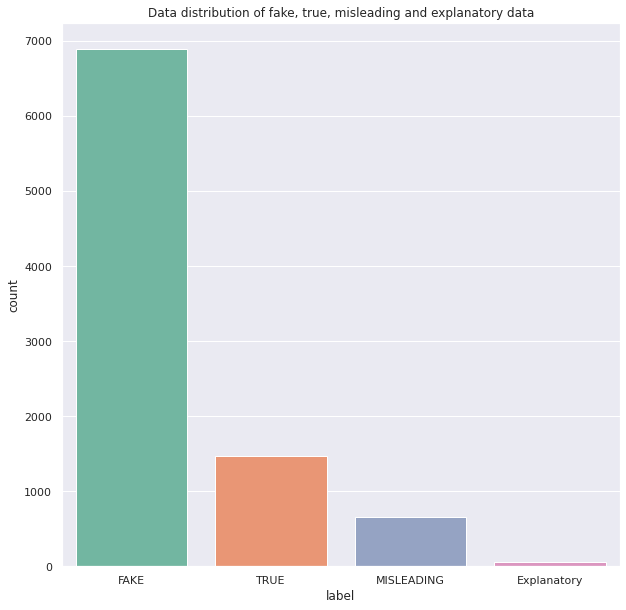

In [ ]:
plt.figure(figsize=(10, 10))
sns.set(style="darkgrid")

color = sns.color_palette("Set2")
ax = sns.countplot(x="label", data=df, palette=color)

ax.set(xticklabels=['FAKE', 'TRUE', 'MISLEADING', 'Explanatory'])

plt.title("Data distribution of fake, true, misleading and explanatory data")

In [ ]:
df1 = df
df1.head()

title  \
0   If you can hold your breath for 10 seconds th...   
1            The movie Venom predicted the epidemic.   
2   A political assistant did not ask media outle...   
3       This is Dr. Li-wen Liang’s funeral ceremony.   
4   “Now, they’re doing tests on airlines — very ...   

                                                text   source label  
0   If you can hold your breath for 10 seconds th...  missing  FAKE  
1            The movie Venom predicted the epidemic.  missing  FAKE  
2   A political assistant did not ask media outle...  missing  FAKE  
3       This is Dr. Li-wen Liang’s funeral ceremony.  missing  FAKE  
4   “Now, they’re doing tests on airlines — very ...  missing  FAKE

### Data Cleaning

In [ ]:
def clean_train_data(x):
    text = x
    text = text.lower()
    text = re.sub('\[.*?\]', '', text) # remove square brackets
    text = re.sub(r'[^\w\s]','',text) # remove punctuation
    text = re.sub('\w*\d\w*', '', text) # remove words containing numbers
    text = re.sub(r'http\S+', '', text)
    text = re.sub('\n', '', text)
    return text

In [ ]:
clean_combine_data = df1.copy()
clean_combine_data['title'] = df1.title.apply(lambda x : clean_train_data(x))
clean_combine_data.head()

title  \
0   if you can hold your breath for  seconds then...   
1             the movie venom predicted the epidemic   
2   a political assistant did not ask media outle...   
3           this is dr liwen liangs funeral ceremony   
4   now theyre doing tests on airlines  very stro...   

                                                text   source label  
0   If you can hold your breath for 10 seconds th...  missing  FAKE  
1            The movie Venom predicted the epidemic.  missing  FAKE  
2   A political assistant did not ask media outle...  missing  FAKE  
3       This is Dr. Li-wen Liang’s funeral ceremony.  missing  FAKE  
4   “Now, they’re doing tests on airlines — very ...  missing  FAKE

In [ ]:
clean_combine_data.tail()

title  \
9072   two chinese nationals in kenya have been kill...   
9073   the cuban antiviral interferon alfa  is used ...   
9074   this video shows a woman eating a bat soup in...   
9075                                            missing   
9076   prime minister ana brnabic claimed that the n...   

                                                   text   source       label  
9072   Two Chinese nationals in Kenya have been kill...  missing        FAKE  
9073   The Cuban antiviral Interferon Alfa 2B is use...  missing  MISLEADING  
9074   This video shows a woman eating a bat soup in...  missing        FAKE  
9075  Read a 2015 article in Nature magazine about e...    Manik        FAKE  
9076   Prime Minister Ana Brnabic claimed that the n...  missing        FAKE

### Stopword Removal


In [ ]:
eng_stopwords = stop_words

In [ ]:
def remove_eng_stopwords(text):
    token_text = nltk.word_tokenize(text)
    remove_stop = [word for word in token_text if word not in eng_stopwords]
    join_text = ' '.join(remove_stop)
    return join_text

In [ ]:
nltk.download('punkt')
stopword_combine_data = clean_combine_data.copy()
stopword_combine_data['title'] = clean_combine_data.title.apply(lambda x : remove_eng_stopwords(x))
stopword_combine_data.head()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


title  \
0  hold breath seconds dont fibrosis therefore in...   
1                     movie venom predicted epidemic   
2  political assistant ask media outlets defame b...   
3                   dr liwen liangs funeral ceremony   
4  theyre tests airlines strong tests getting get...   

                                                text   source label  
0   If you can hold your breath for 10 seconds th...  missing  FAKE  
1            The movie Venom predicted the epidemic.  missing  FAKE  
2   A political assistant did not ask media outle...  missing  FAKE  
3       This is Dr. Li-wen Liang’s funeral ceremony.  missing  FAKE  
4   “Now, they’re doing tests on airlines — very ...  missing  FAKE

### Find out common words

In [ ]:
from itertools import chain
from collections import Counter

In [ ]:
list_words = stopword_combine_data['title'].str.split()
list_words_merge = list(chain(*list_words))

d = Counter(list_words_merge)
df2 = pd.DataFrame(data=d, index=['count'])
top_common_words = df2.T.sort_values(by=['count'], ascending=False).reset_index().head(50)
top_common_words.head()

index  count
0  coronavirus   3576
1       people    840
2        video    833
3        shows    616
4          new    523

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
 <a list of 50 Text major ticklabel objects>)

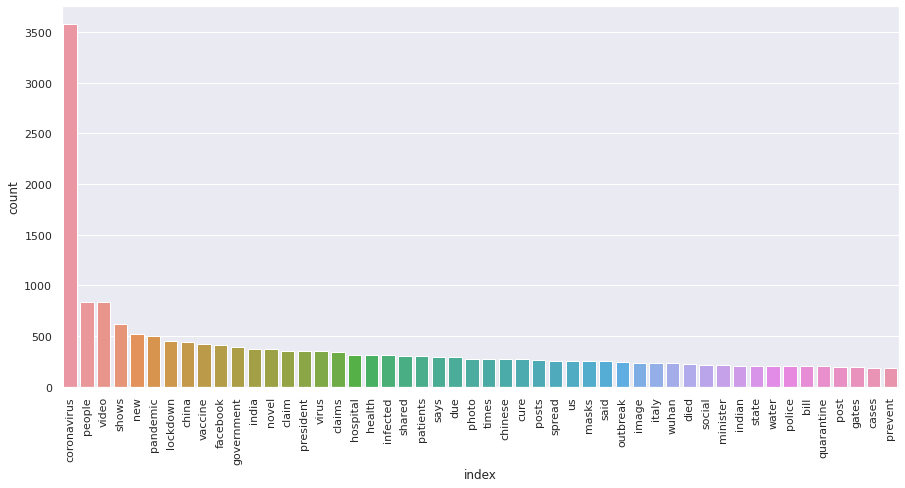

In [ ]:
plt.figure(figsize=(15,7))
sns.set(style="darkgrid")
sns.barplot(x="index", y='count', data=top_common_words)
plt.xticks(rotation=90)

In [ ]:
from nltk.stem import WordNetLemmatizer

In [ ]:
lemm = WordNetLemmatizer()

In [ ]:
def word_lemmatizer(text):
    token_text = nltk.word_tokenize(text)
    remove_stop = [lemm.lemmatize(w) for w in token_text]
    join_text = ' '.join(remove_stop)
    return join_text

In [ ]:
nltk.download('wordnet')
lemmatize_data = stopword_combine_data.copy()
lemmatize_data['title'] = stopword_combine_data.title.apply(lambda x : word_lemmatizer(x))
lemmatize_data.head()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


title  \
0  hold breath second dont fibrosis therefore inf...   
1                     movie venom predicted epidemic   
2  political assistant ask medium outlet defame b...   
3                   dr liwen liangs funeral ceremony   
4  theyre test airline strong test getting gettin...   

                                                text   source label  
0   If you can hold your breath for 10 seconds th...  missing  FAKE  
1            The movie Venom predicted the epidemic.  missing  FAKE  
2   A political assistant did not ask media outle...  missing  FAKE  
3       This is Dr. Li-wen Liang’s funeral ceremony.  missing  FAKE  
4   “Now, they’re doing tests on airlines — very ...  missing  FAKE

### N-Gram Analysis

In [ ]:
string = ' '.join(lemmatize_data['title'])

In [ ]:
str_val = string.split(" ")

### Unigram Analysis

In [ ]:
data_unigram=(pd.Series(nltk.ngrams(str_val, 1)).value_counts())[:30]

In [ ]:
data_unigram_df = pd.DataFrame(data_unigram)
data_unigram_df = data_unigram_df.reset_index()
data_unigram_df = data_unigram_df.rename(columns={"index": "key", 0: "value"})
data_unigram_df.head()

key  value
0  (coronavirus,)   3576
1        (video,)    862
2       (people,)    861
3         (show,)    763
4        (claim,)    701

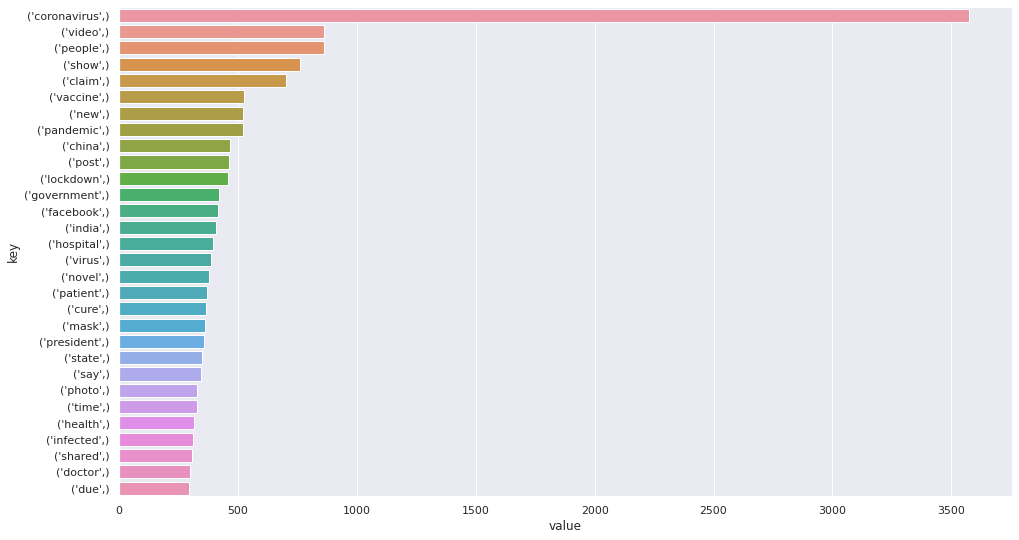

In [ ]:
plt.figure(figsize = (16,9))
sns.barplot(x='value',y='key', data=data_unigram_df)

### Bigram Analysis

In [ ]:
data_bigram = (pd.Series(nltk.ngrams(str_val, 2)).value_counts())[:30]

In [ ]:
data_bigram_df = pd.DataFrame(data_bigram)
data_bigram_df = data_bigram_df.reset_index()
data_bigram_df = data_bigram_df.rename(columns={"index": "key", 0: "value"})
data_bigram_df.head()

key  value
0     (novel, coronavirus)    371
1       (new, coronavirus)    305
2            (video, show)    244
3  (coronavirus, pandemic)    172
4         (thousand, time)    162

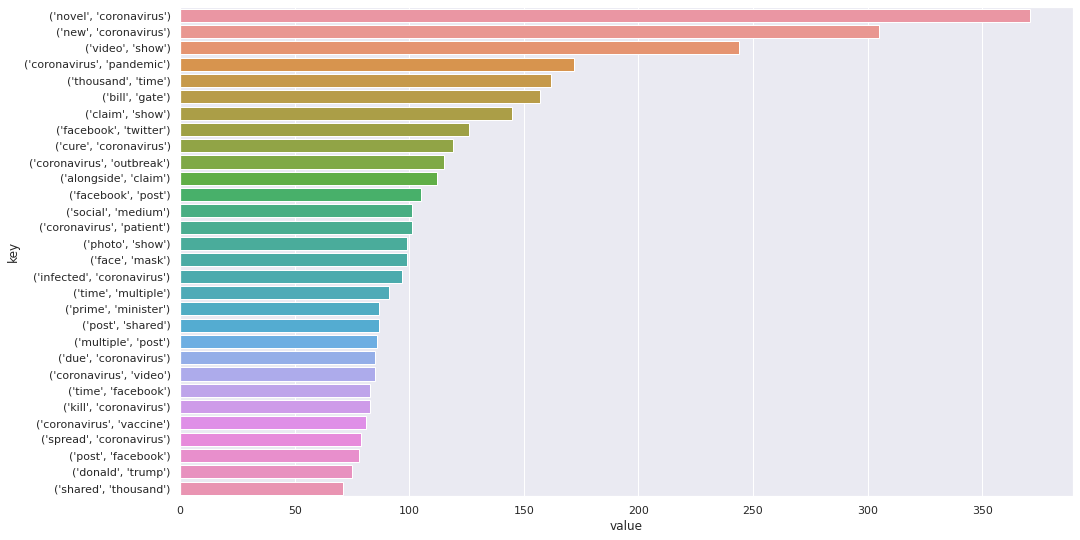

In [ ]:
plt.figure(figsize = (16,9))
sns.barplot(x='value',y='key', data=data_bigram_df)

### Trigram Analysis

In [ ]:
data_trigram = (pd.Series(nltk.ngrams(str_val, 3)).value_counts())[:30]

In [ ]:
data_trigram_df = pd.DataFrame(data_trigram)
data_trigram_df = data_trigram_df.reset_index()
data_trigram_df = data_trigram_df.rename(columns={"index": "key", 0: "value"})
data_trigram_df.head()

key  value
0    (alongside, claim, show)     83
1    (shared, thousand, time)     71
2  (multiple, post, facebook)     68
3  (thousand, time, multiple)     67
4      (time, multiple, post)     59

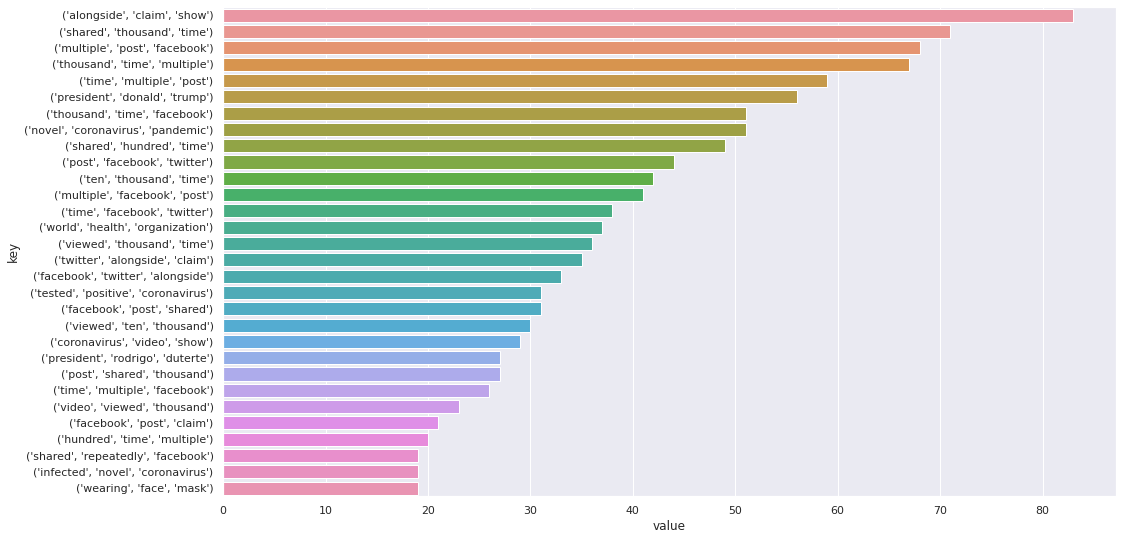

In [ ]:
plt.figure(figsize = (16,9))
sns.barplot(x='value',y='key', data=data_trigram_df)

### Modeling

In [ ]:
model_data = lemmatize_data.copy()
model_data['combine_title'] = model_data['title']
model_data = model_data[['label', 'combine_title']]

model_data.head()

label                                      combine_title
0  FAKE  hold breath second dont fibrosis therefore inf...
1  FAKE                     movie venom predicted epidemic
2  FAKE  political assistant ask medium outlet defame b...
3  FAKE                   dr liwen liangs funeral ceremony
4  FAKE  theyre test airline strong test getting gettin...

In [ ]:
# %matplotlib inline
from wordcloud import WordCloud
all_words = ' '.join([text for text in model_data.combine_title])

wordcloud = WordCloud(width= 800, height= 500,
                          max_font_size = 110,
                          collocations = False).generate(all_words)

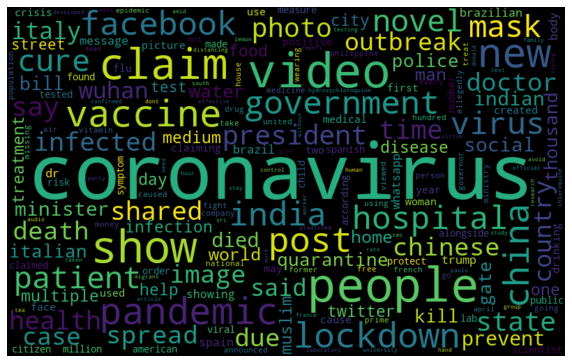

In [ ]:
plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

We will divide the data in to fake, true and misleading catagories

In [ ]:
def wordcloud_true(text, column_title):
    true_text = text.query("label == 'TRUE'")
    all_words = ' '.join([text for text in true_text[column_title]])

    wordcloud = WordCloud(width= 800, height= 500,
                              max_font_size = 110,
                              collocations = False).generate(all_words)
    plt.figure(figsize=(10,7))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

In [ ]:
def wordcloud_fake(text, column_title):
    fake_text = text.query("label == 'FAKE'")
    all_words = ' '.join([text for text in fake_text[column_title]])

    wordcloud = WordCloud(width= 800, height= 500,
                              max_font_size = 110,
                              collocations = False).generate(all_words)
    plt.figure(figsize=(10,7))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

In [ ]:
def wordcloud_misleading(text, column_title):
    misleading_text = text.query("label == 'MISLEADING'")
    all_words = ' '.join([text for text in misleading_text[column_title]])

    wordcloud = WordCloud(width= 800, height= 500,
                              max_font_size = 110,
                              collocations = False).generate(all_words)
    plt.figure(figsize=(10,7))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

In [ ]:
def wordcloud_explanatory(text, column_title):
    explanatory_text = text.query("label == 'Explanatory'")
    all_words = ' '.join([text for text in explanatory_text[column_title]])

    wordcloud = WordCloud(width= 800, height= 500,
                              max_font_size = 110,
                              collocations = False).generate(all_words)
    plt.figure(figsize=(10,7))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

### Wordcloud of the true news. 

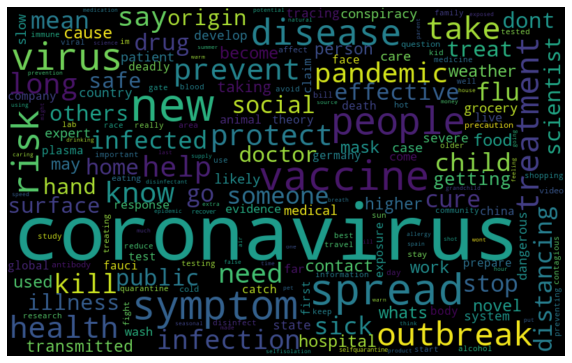

In [ ]:
wordcloud_true(model_data, "combine_title")

### Wordcloud of the fake news.

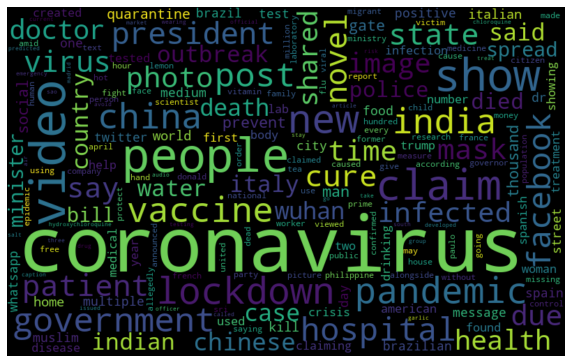

In [ ]:
wordcloud_fake(model_data, "combine_title")

### Wordcloud of the misleading news.


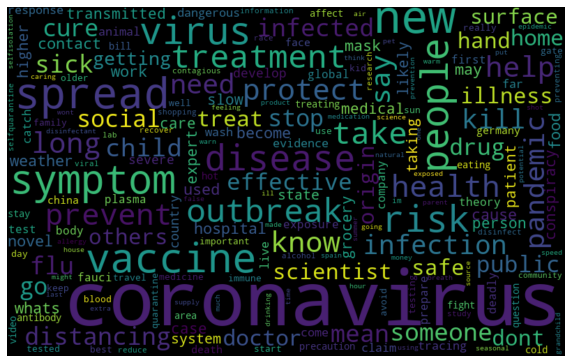

In [ ]:
wordcloud_true(model_data, "combine_title")

### Wordcloud of the explanatory news.


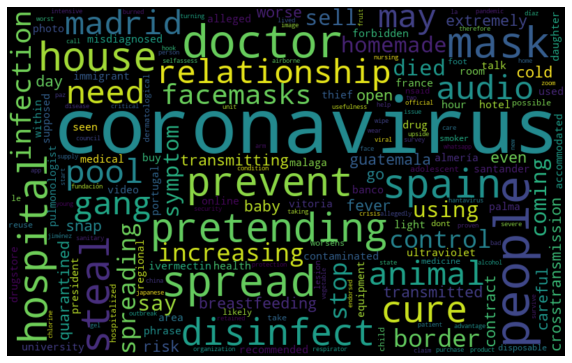

In [ ]:
wordcloud_explanatory(model_data, "combine_title")

**Frequencies of Words**

Now we will plot the pareto chart to better visualize the frequencies of the words.

In [ ]:
from nltk import tokenize
token_space = tokenize.WhitespaceTokenizer()

In [ ]:
def pareto(text, column_title, quantity):
    all_words = ' '.join([text for text in text[column_title]])
    token_phrase = token_space.tokenize(all_words)
    frequency = nltk.FreqDist(token_phrase)
    df_frequency = pd.DataFrame({"Word": list(frequency.keys()),
                                   "Frequency": list(frequency.values())})
    df_frequency = df_frequency.nlargest(columns = "Frequency", n = quantity)
    plt.figure(figsize=(12,8))
    ax = sns.barplot(data = df_frequency, x = "Word", y = "Frequency", color = 'blue')
    ax.set(ylabel = "Count")
    plt.show()

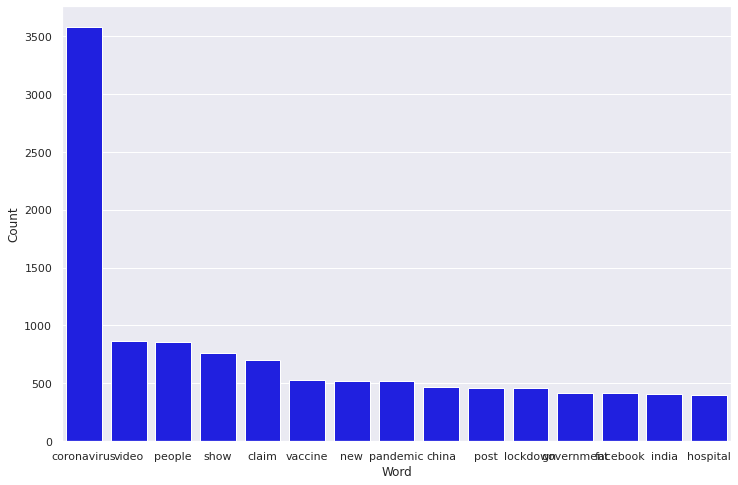

In [ ]:
pareto(model_data, "combine_title", 15)

In [ ]:
model_data[model_data['label']=='MISLEADING']

label                                      combine_title
9     MISLEADING              coronavirus float air grounded unicef
22    MISLEADING  video claim show plane carrying medical supply...
27    MISLEADING  lysol disinfectant label say tested new corona...
28    MISLEADING  temporary closure supermarket store bakery ann...
29    MISLEADING                     photo show aid crew cuba italy
...          ...                                                ...
9055  MISLEADING  chinese vaccine tested brazil antiethical test...
9065  MISLEADING   gargling hot water prevent coronavirus infection
9067  MISLEADING  israeli minister health provides information c...
9070  MISLEADING  photo petri bowl germ shared facebook claim ba...
9073  MISLEADING  cuban antiviral interferon alfa used china tre...

[1464 rows x 2 columns]

In [ ]:
model_data[model_data['label']=='Explanatory']

label                                      combine_title
50    Explanatory  relationship breastfeeding risk transmitting c...
107   Explanatory           homemade mask prevent spread coronavirus
163   Explanatory   audio state worst coronavirus crisis spain start
846   Explanatory   pool open guatemala coronavirus transmitted pool
922   Explanatory                  usefulness homemade chlorine wipe
978   Explanatory  extremely careful coming cold snap get fever n...
1067  Explanatory                   coronavirus spread people animal
1451  Explanatory  gang vitoria pretending doctor steal people house
1774  Explanatory  extremely careful coming cold snap get fever n...
1822  Explanatory                 security issue zoom video call app
1918  Explanatory  using drug ivermectin cure coronavirus within ...
1948  Explanatory  audio alleged pulmonologist regional universit...
2035  Explanatory  using drug ivermectin cure coronavirus within ...
2386  Explanatory  ultraviolet light used disinfect area contamin...
2419  Explanatory  photo room hotel almería spain immigrant accom...
2469  Explanatory  relationship breastfeeding risk transmitting c...
3027  Explanatory           drugstore france forbidden buy sell mask
3156  Explanatory  thief palma spain pretending doctor steal peop...
3533  Explanatory  supposed phrase daughter president banco santa...
3537  Explanatory  viral audio whatsapp doctor hospital fundación...
3643  Explanatory            facemasks prevent coronavirus infection
4016  Explanatory  increasing border control stop coronavirus spr...
4061  Explanatory                 coronavirus spread fruit vegetable
4168  Explanatory            facemasks prevent coronavirus infection
4247  Explanatory   pool open guatemala coronavirus transmitted pool
4334  Explanatory  purchase health product health council taking ...
4411  Explanatory  photo room hotel almería spain immigrant accom...
4485  Explanatory  thief palma spain pretending doctor steal peop...
4720  Explanatory      new outbreak pandemic hantavirus coming china
4721  Explanatory  gang vitoria pretending doctor steal people house
4738  Explanatory  turning severe person coronavirus upside help ...
4992  Explanatory  increasing border control stop coronavirus spr...
5201  Explanatory  audio alleged pulmonologist regional universit...
5320  Explanatory        recommended disinfect disposable mask reuse
5372  Explanatory          smoker le likely hospitalized coronavirus
5686  Explanatory  video say japanese doctor proven coronavirus a...
5884  Explanatory            facemasks prevent coronavirus infection
5947  Explanatory  ultraviolet light used disinfect area contamin...
6260  Explanatory           drugstore france forbidden buy sell mask
6388  Explanatory  dermatological lesion foot child adolescent po...
6576  Explanatory   people died coronavirus spain lived nursing home
6802  Explanatory                          coronavirus spread animal
6865  Explanatory            facemasks prevent coronavirus infection
7063  Explanatory  supposed phrase daughter president banco santa...
7071  Explanatory                          coronavirus spread animal
7244  Explanatory   gang madrid pretending doctor steal people house
7247  Explanatory                   coronavirus spread people animal
7345  Explanatory  dermatological lesion foot child adolescent po...
7368  Explanatory       online survey selfassess coronavirus symptom
7393  Explanatory  sanitary protection supply retained la paz hos...
7517  Explanatory           dont take nsaid medicine worsens symptom
7900  Explanatory           dont take nsaid medicine worsens symptom
8130  Explanatory  image arm burned allegedly using gel alcohol d...
8143  Explanatory  increasing border control stop coronavirus spr...
8177  Explanatory           homemade mask prevent spread coronavirus
8194  Explanatory  increasing border control stop coronavirus spr...
8344  Explanatory        recommended disinfect disposable mask reuse
8390  Expl

In [ ]:
model_data = model_data.sample(frac=1).reset_index(drop=True)
model_data

label                                      combine_title
0           FAKE  video show italian governmentbrisbane police u...
1           FAKE    smelling vinegar definitive test detect symptom
2           FAKE  per aajtak news channel pm narendra modi annou...
3           FAKE  helicopter used spray disinfectant air eradica...
4     MISLEADING  photo making round social medium claim show pe...
...          ...                                                ...
9072        FAKE  lee kum kee doctor scientist graduated china c...
9073        FAKE  paramilitary force deployed surat rajkot barod...
9074        FAKE      gargling salt water protect washing virus gut
9075        FAKE  outbreak taiwan control president tsai ordered...
9076        FAKE  china successfully tested anticoronavirus seru...

[9077 rows x 2 columns]

In [ ]:
model_data = model_data[model_data.label != 'Explanatory']
Counter(model_data['label'])

Counter({'FAKE': 6896, 'MISLEADING': 1464, 'TRUE': 658})

In [ ]:
model_data['combine_title']

0       video show italian governmentbrisbane police u...
1         smelling vinegar definitive test detect symptom
2       per aajtak news channel pm narendra modi annou...
3       helicopter used spray disinfectant air eradica...
4       photo making round social medium claim show pe...
                              ...                        
9072    lee kum kee doctor scientist graduated china c...
9073    paramilitary force deployed surat rajkot barod...
9074        gargling salt water protect washing virus gut
9075    outbreak taiwan control president tsai ordered...
9076    china successfully tested anticoronavirus seru...
Name: combine_title, Length: 9018, dtype: object

###**Logistic Regression**

In [ ]:
def preprocessor(text):
    
    text = re.sub('<[^>]*>', '', text)
    text = re.sub(r'[^\w\s]','', text)
    text = text.lower()

    return text

In [ ]:
model_data['combine_title'] = model_data['combine_title'].apply(preprocessor)

In [ ]:
porter = PorterStemmer()

def tokenizer_porter(text):
    return [porter.stem(word) for word in text.split()]

In [ ]:
tfidf = TfidfVectorizer(strip_accents=None,
                        lowercase=False,
                        preprocessor=None,
                        tokenizer=tokenizer_porter,
                        use_idf=True,
                        norm='l2',
                        smooth_idf=True)
X_1 = tfidf.fit_transform(model_data['combine_title'])
y_1 = model_data.label.values

### Split Data & Modelling (Logistic Regression)

In [ ]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_1, y_1, random_state=0, test_size=0.5, shuffle=False)

In [ ]:
clf2 = LogisticRegressionCV(cv=5, scoring='accuracy', random_state=0, n_jobs=-1, verbose=3, max_iter=300).fit(X_train1, y_train1)

fake_news_model = open('fake_news_model.sav', 'wb')
pickle.dump(clf2, fake_news_model)
fake_news_model.close()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   34.6s finished


In [ ]:

filename = 'fake_news_model.sav'
saved_clf = pickle.load(open(filename, 'rb'))

saved_clf.score(X_test1, y_test1)

0.7686848525171879

In [ ]:

y_pred1 = clf2.predict(X_test1)
print("---Test Set Results---")
print("Accuracy with logreg: {}".format(accuracy_score(y_test1, y_pred1)))
print(classification_report(y_test1, y_pred1))

---Test Set Results---
Accuracy with logreg: 0.7686848525171879
              precision    recall  f1-score   support

        FAKE       0.79      0.96      0.87      3422
  MISLEADING       0.39      0.11      0.18       741
        TRUE       0.75      0.27      0.40       346

    accuracy                           0.77      4509
   macro avg       0.64      0.45      0.48      4509
weighted avg       0.72      0.77      0.72      4509



###**Naive Bayes**

In [ ]:
length_doc_text = model_data['combine_title']
length_lebel = model_data['label']
split_point_1 = int(0.80*len(length_doc_text))
trainDoc_1 = length_doc_text[:split_point_1]
trainClass_1 = length_lebel[:split_point_1]
testDoc_1 = length_doc_text[split_point_1:]
testClass_1 = length_lebel[split_point_1:]

In [ ]:
testData = model_data.sample(frac=1).reset_index(drop=True)
testData

label                                      combine_title
0     TRUE  particular coronavirus compare coronaviruses l...
1     FAKE  ecuadorian youtuber raùl alvarez guene suppose...
2     FAKE    italy decrease number politician reduce expense
3     FAKE       italian threw away currency street due death
4     FAKE  interview australian newspaper official said i...
...    ...                                                ...
9013  FAKE                                               pope
9014  FAKE  rudy giuliani hint possible investigation obam...
9015  FAKE  mla hafeez khan forced nurse touch foot muslim...
9016  FAKE  senegalese doctor say chloroquine secret low n...
9017  FAKE  chinese traditional medicine shufengjiedu caps...

[9018 rows x 2 columns]

In [ ]:

from collections import Counter

testClassList = testClass_1.tolist()
Counter(testClassList)

Counter({'FAKE': 1378, 'MISLEADING': 286, 'TRUE': 140})

In [ ]:

# a dummy function that just returns its input
def identity(x):
    return x

In [ ]:

def Multinomial_Naive_Bayes(trainDoc, trainClass, testDoc, testClass, tfIdf):

    # we use a dummy function as tokenizer and preprocessor,
    # since the texts are already preprocessed and tokenized.
    if tfIdf:
        vec = TfidfVectorizer(preprocessor = identity,
                              tokenizer = identity)
   

    # Pipeline combines the vectorizers with a Naive Bayes classifier
    classifier = Pipeline( [('vec', vec),
                            ('cls', MultinomialNB(alpha=.01))] )


    # Train the classifier and build a model using the training documents
    classifier.fit(trainDoc, trainClass)
    
    #saving the model
    from sklearn.externals import joblib
    joblib.dump(classifier, 'NB_model.pkl')
    
    # Outputs Predicted class for the test set
    testGuess = classifier.predict(testDoc)
    
#     try:
#         #inputfile = open("input_nb.txt","r", encoding='utf-8')
#         valDOC, valLBL = read_corpus('input_nb.txt', use_sentiment=False)
#         predz = classifier.predict(valDOC)
#         i=0
#         for line in valDOC:
#             print(line, predz[i])
#             i+=1
#         #inputfile.close()
#     except:
#         pass

    prec, rec, f1, tureSum= precision_recall_fscore_support(testClass, testGuess)
    #classguess = classifier.predict(predict)
    #print("predicted class:", classguess)

    # Simply calculates the accuracy score using the Gold Labels and Predicted Labels
    print("Naive Bayes with TF-idf:")
    accuracy = accuracy_score(testClass, testGuess)
    print("Accuracy = "+str(accuracy))
    print("\n")
    # Showing the Confusion Matrix
    print("\nConfusion Matrix:")
    cm = confusion_matrix(testClass, testGuess, labels=classifier.classes_)
    prec, rec, f1, tureSum= precision_recall_fscore_support(testClass, testGuess)
    print(classifier.classes_)
    print(cm)
    print('\n\n...........Classification Report...........')
    print(classification_report(testClass, testGuess))


In [ ]:

Multinomial_Naive_Bayes(trainDoc_1, trainClass_1, testDoc_1, testClass_1, tfIdf=True)

Naive Bayes with TF-idf:
Accuracy = 0.7638580931263859



Confusion Matrix:
['FAKE' 'MISLEADING' 'TRUE']
[[1378    0    0]
 [ 286    0    0]
 [ 140    0    0]]


...........Classification Report...........
              precision    recall  f1-score   support

        FAKE       0.76      1.00      0.87      1378
  MISLEADING       0.00      0.00      0.00       286
        TRUE       0.00      0.00      0.00       140

    accuracy                           0.76      1804
   macro avg       0.25      0.33      0.29      1804
weighted avg       0.58      0.76      0.66      1804



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [ ]:
df['title_num_uppercase'] = df['title'].str.count(r'[A-Z]')
df['title_len'] = df['title'].str.len()

df['text_num_uppercase'] = df['text'].str.count(r'[A-Z]')
df['text_len'] = df['text'].str.len()

df['title_pct_uppercase'] = df.title_num_uppercase.div(df.title_len)
df['text_pct_uppercase'] = df.text_num_uppercase.div(df.text_len)
df

title  \
0      If you can hold your breath for 10 seconds th...   
1               The movie Venom predicted the epidemic.   
2      A political assistant did not ask media outle...   
3          This is Dr. Li-wen Liang’s funeral ceremony.   
4      “Now, they’re doing tests on airlines — very ...   
...                                                 ...   
9072   Two Chinese nationals in Kenya have been kill...   
9073   The Cuban antiviral Interferon Alfa 2B is use...   
9074   This video shows a woman eating a bat soup in...   
9075                                            missing   
9076   Prime Minister Ana Brnabic claimed that the n...   

                                                   text   source       label  \
0      If you can hold your breath for 10 seconds th...  missing        FAKE   
1               The movie Venom predicted the epidemic.  missing        FAKE   
2      A political assistant did not ask media outle...  missing        FAKE   
3          This is Dr. Li-wen Liang’s funeral ceremony.  missing        FAKE   
4      “Now, they’re doing tests on airlines — very ...  missing        FAKE   
...                                                 ...      ...         ...   
9072   Two Chinese nationals in Kenya have been kill...  missing        FAKE   
9073   The Cuban antiviral Interferon Alfa 2B is use...  missing  MISLEADING   
9074   This video shows a woman eating a bat soup in...  missing        FAKE   
9075  Read a 2015 article in Nature magazine about e...    Manik        FAKE   
9076   Prime Minister Ana Brnabic claimed that the n...  missing        FAKE   

      title_num_uppercase  title_pct_uppercase  title_num_stop_words  \
0                       3             0.020000                    11   
1                       2             0.050000                     1   
2                       5             0.053191                     3   
3                       4             0.088889                     1   
4                       2             0.013605                     4   
...                   ...                  ...                   ...   
9072                    5             0.044248                     7   
9073                    6             0.060000                     5   
9074                    2             0.037736                     2   
9075                    0             0.000000                     0   
9076                    4             0.039216                     7   

      title_pct_stop_words  NNP_title   IN  PRP   MD   VB  PRP$   NN   CD  \
0                 0.423077        1.0  4.0  2.0  1.0  1.0   1.0  5.0  1.0   
1                 0.166667        1.0  0.0  0.0  0.0  0.0   0.0  2.0  0.0   
2                 0.214286        3.0  0.0  0.0  0.0  2.0   0.0  1.0  0.0   
3                 0.142857        4.0  0.0  0.0  0.0  0.0   0.0  1.0  0.0   
4                 0.153846        0.0  5.0  2.0  0.0  0.0   0.0  1.0  0.0   
...                    ...        ...  ...  ...  ...  ...   ...  ...  ...   
9072              0.411765        3.0  4.0  0.0  0.0  0.0   0.0  1.0  1.0   
9073              0.294118        4.0  2.0  0.0  0.0  1.0   0.0  1.0  1.0   
9074              0.181818        1.0  1.0  0.0  0.0  0.0   0.0  4.0  0.0   
9075              0.000000        0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0   
9076              0.411765        4.0  3.0  0.0  0.0  0.0   0.0  3.0  0.0   

      NNS   RB  VBP   JJ  VBN   CC   DT    .  NNP  VBG  VBD   TO  VBZ    ,  \
0     2.0  2.0  2.0  1.0  1.0  1.0  2.0  2.0  1.0  1.0  0.0  0.0  0.0  0.0   
1     0.0  0.0  0.0  0.0  0.0  0.0  2.0  1.0  1.0  0.0  1.0  0.0  0.0  0.0   
2     2.0  1.0  0.0  2.0  0.0  0.0  1.0  1.0  3.0  0.0  1.0  1.0  0.0  0.0   
3     0.0  0.0  0.0  1.0  0.0  0.0  1.0  1.0  4.0  0.0  0.0  0.0  2.0  0.0   
4     5.0  3.0  3.0  5.0  0.0  0.0  0.0  2.0  0.0  6.0  0.0  0.0  0.0  3.0   
...   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
9072  1.0  1.0  1.0  1.0  2.0  0.0  1.0  1.0

In [ ]:
df['title_num_stop_words'] = df['title'].str.split().apply(lambda x: len(set(x) & stop_words))
df['text_num_stop_words'] = df['text'].str.split().apply(lambda x: len(set(x) & stop_words))

df['title_word_count'] = df['title'].apply(lambda x: len(str(x).split()))
df['text_word_count'] = df['text'].apply(lambda x: len(str(x).split()))

df['title_pct_stop_words'] = df['title_num_stop_words'] / df['title_word_count']
df['text_pct_stop_words'] = df['text_num_stop_words'] / df['text_word_count']
df.head()

title  \
0   If you can hold your breath for 10 seconds th...   
1            The movie Venom predicted the epidemic.   
2   A political assistant did not ask media outle...   
3       This is Dr. Li-wen Liang’s funeral ceremony.   
4   “Now, they’re doing tests on airlines — very ...   

                                                text   source label  \
0   If you can hold your breath for 10 seconds th...  missing  FAKE   
1            The movie Venom predicted the epidemic.  missing  FAKE   
2   A political assistant did not ask media outle...  missing  FAKE   
3       This is Dr. Li-wen Liang’s funeral ceremony.  missing  FAKE   
4   “Now, they’re doing tests on airlines — very ...  missing  FAKE   

   title_num_uppercase  title_pct_uppercase  title_num_stop_words  \
0                    3             0.020000                    11   
1                    2             0.050000                     1   
2                    5             0.053191                     3   
3                    4             0.088889                     1   
4                    2             0.013605                     4   

   title_pct_stop_words  NNP_title   IN  PRP   MD   VB  PRP$   NN   CD  NNS  \
0              0.423077        1.0  4.0  2.0  1.0  1.0   1.0  5.0  1.0  2.0   
1              0.166667        1.0  0.0  0.0  0.0  0.0   0.0  2.0  0.0  0.0   
2              0.214286        3.0  0.0  0.0  0.0  2.0   0.0  1.0  0.0  2.0   
3              0.142857        4.0  0.0  0.0  0.0  0.0   0.0  1.0  0.0  0.0   
4              0.153846        0.0  5.0  2.0  0.0  0.0   0.0  1.0  0.0  5.0   

    RB  VBP   JJ  VBN   CC   DT    .  NNP  VBG  VBD   TO  VBZ    ,   RP  PDT  \
0  2.0  2.0  1.0  1.0  1.0  2.0  2.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  0.0  2.0  1.0  1.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0   
2  1.0  0.0  2.0  0.0  0.0  1.0  1.0  3.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0   
3  0.0  0.0  1.0  0.0  0.0  1.0  1.0  4.0  0.0  0.0  0.0  2.0  0.0  0.0  0.0   
4  3.0  3.0  5.0  0.0  0.0  0.0  2.0  0.0  6.0  0.0  0.0  0.0  3.0  2.0  0.0   

    WP  WDT    (    )  WRB  JJR   EX    :   ''  NNPS  JJS   FW  RBR    $   ``  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0   
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0   
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0   
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0   

    UH  POS    #  RBS  WP$  num_negation  num_interrogatives_title  \
0  0.0  0.0  0.0  0.0  0.0             1                         0   
1  0.0  0.0  0.0  0.0  0.0             1                         0   
2  0.0  0.0  0.0  0.0  0.0             1                         0   
3  0.0  0.0  0.0  0.0  0.0             0                         0   
4  0.0  0.0  0.0  0.0  0.0             1                         0   

   num_interrogatives_text  flesch_reading_ease  smog_index  \
0                        0                75.20         0.0   
1                        0                31.55         0.0   
2                        0                31.89         0.0   
3                        0                34.08         0.0   
4                        0                83.66         0.0   

   flesch_kincaid_grade  automated_readability_index  \
0                   6.0                          7.5   
1                  10.4                          8.3   
2                  12.3                         12.5   
3                   9.4                          5.9   
4                   4.8                          7.0   

   dale_chall_readability_score  difficult_words  linsear_write_formula  \
0                          7.32                5                   7.00   
1                         11.83                3                   4.00   
2                         13.35                8               

### Stop Words in Title

In [ ]:
# x1 = df.loc[df['label']=='TRUE']['title_num_stop_words']
# x2 = df.loc[df['label'] == 'FAKE']['title_num_stop_words']
# x3 = df.loc[df['label'] == 'MISLEADING']['title_num_stop_words']
# x4 = df.loc[df['label'] == 'Explanatory']['title_num_stop_words']
# # x5 = df.loc[df['label'] == 'Partly false']['title_num_stop_words']
# # x6 = df.loc[df['label'] == 'Partially True']['title_num_stop_words']



# group_labels = ['TRUE', 'FAKE', 'MISLEADING', 'Explanatory']

# colors = ['rgb(0, 0, 255)', 'rgb(135, 206, 250)', 'rgb(255, 0, 0)', 'rgb(0, 255, 0)']

# fig = ff.create_distplot(
#     [x1, x2, x3, x4], group_labels,colors=colors)

# fig.update_layout(title_text='Distribution of Stop Words in title', template="plotly_white")
# fig.show()

In [ ]:
# df['label'].isnull().sum()

In [ ]:
# fig = go.Figure()
# fig.add_trace(go.Box(y=x1, name='TRUE',
#                 marker_color = 'rgb(0, 0, 255)'))
# fig.add_trace(go.Box(y=x2, name = 'FAKE',
#                 marker_color = 'rgb(135, 206, 250)'))
# fig.add_trace(go.Box(y=x3, name = 'MISLEADING',
#                 marker_color = 'rgb(255, 0, 0)'))
# fig.add_trace(go.Box(y=x4, name = 'Explanatory',
#                 marker_color = 'rgb(0, 255, 0)'))
# fig.update_layout(title_text='Box plot of Stop Words in title', template="plotly_white")
# fig.show()

### Capital Letter in Title

In [ ]:
x1 = df.loc[df['label']=='TRUE']['title_num_uppercase']
x2 = df.loc[df['label'] == 'FAKE']['title_num_uppercase']
x3 = df.loc[df['label'] == 'MISLEADING']['title_num_uppercase']
x4 = df.loc[df['label'] == 'Explanatory']['title_num_uppercase']

group_labels = ['TRUE', 'FAKE', 'MISLEADING', 'Explanatory']

colors = ['rgb(0, 0, 255)', 'rgb(135, 206, 250)', 'rgb(255, 0, 0)', 'rgb(0, 255, 0)']

fig = ff.create_distplot(
    [x1, x2, x3, x4], group_labels,colors=colors)

fig.update_layout(title_text='Distribution of Capital letter in title', template="plotly_white")
fig.show()

In [ ]:
fig = go.Figure()
fig.add_trace(go.Box(y=x1, name='TRUE',
                marker_color = 'rgb(0, 0, 100)'))
fig.add_trace(go.Box(y=x2, name = 'FAKE',
                marker_color = 'rgb(0, 200, 200)'))
fig.add_trace(go.Box(y=x3, name = 'MISLEADING',
                marker_color = 'rgb(204, 0, 102)'))
fig.add_trace(go.Box(y=x4, name = 'Explanatory',
                marker_color = 'rgb(0, 255, 0)'))
fig.update_layout(title_text='Box plot of Capital Letter in title', template="plotly_white")
fig.show()

On average, fake news have way more words that appear in capital letters in the title.This makes us to think that fake news is targeted for audiences who are likely to be influenced by titles. On the otherside real news have very few capital letters in text than fake and misleading news. Explanatory news have few capital letters among all.

In [ ]:
df.loc[df['label']=='TRUE']['title_num_uppercase'].describe()

count    658.000000
mean       4.407295
std        5.008797
min        0.000000
25%        1.000000
50%        3.000000
75%        6.000000
max       60.000000
Name: title_num_uppercase, dtype: float64

In [ ]:
df.loc[df['label']=='FAKE']['title_num_uppercase'].describe()

count    6896.000000
mean        6.030887
std         8.325977
min         0.000000
25%         2.000000
50%         4.000000
75%         7.000000
max       140.000000
Name: title_num_uppercase, dtype: float64

In [ ]:
df.loc[df['label']=='MISLEADING']['title_num_uppercase'].describe()

count    1464.000000
mean        4.785519
std         3.616875
min         0.000000
25%         2.000000
50%         4.000000
75%         7.000000
max        34.000000
Name: title_num_uppercase, dtype: float64

In [ ]:
df.loc[df['label']=='Explanatory']['title_num_uppercase'].describe()

count    59.000000
mean      2.627119
std       2.083584
min       1.000000
25%       1.000000
50%       2.000000
75%       3.500000
max       7.000000
Name: title_num_uppercase, dtype: float64

In [ ]:
df.drop(['text_num_uppercase', 'text_num_stop_words'], axis=1, inplace=True)

In [ ]:
nltk.download('averaged_perceptron_tagger')
df['token'] = df.apply(lambda row: nltk.word_tokenize(row['title']), axis=1)
df['pos_tags'] = df.apply(lambda row: nltk.pos_tag(row['token']), axis=1)

tag_count_df = pd.DataFrame(df['pos_tags'].map(lambda x: Counter(tag[1] for tag in x)).to_list())

df = pd.concat([df, tag_count_df], axis=1).fillna(0).drop(['pos_tags', 'token'], axis=1)

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [ ]:
df = df[['title', 'text', 'source', 'label', 'title_num_uppercase', 'title_pct_uppercase', 'title_num_stop_words', 'title_pct_stop_words', 'NNP']].rename(columns={'NNP': 'NNP_title'})



In [ ]:
x1 = df.loc[df['label']=='TRUE']['NNP_title']
x2 = df.loc[df['label'] == 'FAKE']['NNP_title']
x3 = df.loc[df['label'] == 'MISLEADING']['NNP_title']
x4 = df.loc[df['label'] == 'Explanatory']['NNP_title']

group_labels = ['TRUE', 'FAKE', 'MISLEADING', 'Explanatory']

colors = ['rgb(0, 0, 255)', 'rgb(135, 206, 250)', 'rgb(255, 0, 0)', 'rgb(0, 255, 0)']

fig = ff.create_distplot(
    [x1, x2, x3, x4], group_labels,colors=colors)

fig.update_layout(title_text='Distribution of Proper nouns in text', template="plotly_white")
fig.show()

PlotlyError: ignored

In [ ]:
fig = go.Figure()
fig.add_trace(go.Box(y=x1, name='TRUE',
                marker_color = 'rgb(0, 0, 100)'))
fig.add_trace(go.Box(y=x2, name = 'FAKE',
                marker_color = 'rgb(0, 200, 200)'))
fig.add_trace(go.Box(y=x3, name = 'MISLEADING',
                marker_color = 'rgb(204, 0, 102)'))
fig.add_trace(go.Box(y=x4, name = 'Explanatory',
                marker_color = 'rgb(0, 255, 0)'))
fig.update_layout(title_text='Box plot of Proper nouns in text', template="plotly_white")
fig.show()

Fake news have more proper nouns. Apparently the use of proper nouns in titles are very significant in differentiating fake from real.

Overall, these results suggest that the writers of fake news are attempting to attracting attention by using all capitalized words, and squeeze as much substance into the titles as possible by skipping stop-words and increase proper nouns. 

Here is an example: 

Fake news: "FULL TRANSCRIPT OF “SMOKING GUN” BOMBSHELL INTERVIEW: PROF. FRANCES BOYLE EXPOSES THE BIOWEAPONS ORIGINS OF THE COVID-19 CORONAVIRUS"

Real news: "Why outbreaks like coronavirus spread exponentially, and how to 'flatten the curve'"

On the otherhand misleading news have less propoer nouns among others.

We will find out whether these apply to article bodies shortly.

In [ ]:
df.loc[df['label']=='TRUE']['NNP_title'].describe()

In [ ]:
df.loc[df['label']=='FAKE']['NNP_title'].describe()

In [ ]:
df.loc[df['label']=='MISLEADING']['NNP_title'].describe()

In [ ]:
df.loc[df['label']=='Explanatory']['NNP_title'].describe()

In [ ]:
df['token'] = df.apply(lambda row: nltk.word_tokenize(row['title']), axis=1)
df['pos_tags'] = df.apply(lambda row: nltk.pos_tag(row['token']), axis=1)

tag_count_df = pd.DataFrame(df['pos_tags'].map(lambda x: Counter(tag[1] for tag in x)).to_list())

df = pd.concat([df, tag_count_df], axis=1).fillna(0).drop(['pos_tags', 'token'], axis=1)
df

In [ ]:
df['num_negation'] = df['title'].str.lower().str.count("no|not|never|none|nothing|nobody|neither|nowhere|hardly|scarcely|barely|doesn’t|isn’t|wasn’t|shouldn’t|wouldn’t|couldn’t|won’t|can't|don't")

df['num_interrogatives_title'] = df['title'].str.lower().str.count("what|who|when|where|which|why|how")
df['num_interrogatives_text'] = df['text'].str.lower().str.count("what|who|when|where|which|why|how")
df.head()

title  \
0   If you can hold your breath for 10 seconds th...   
1            The movie Venom predicted the epidemic.   
2   A political assistant did not ask media outle...   
3       This is Dr. Li-wen Liang’s funeral ceremony.   
4   “Now, they’re doing tests on airlines — very ...   

                                                text   source label  \
0   If you can hold your breath for 10 seconds th...  missing  FAKE   
1            The movie Venom predicted the epidemic.  missing  FAKE   
2   A political assistant did not ask media outle...  missing  FAKE   
3       This is Dr. Li-wen Liang’s funeral ceremony.  missing  FAKE   
4   “Now, they’re doing tests on airlines — very ...  missing  FAKE   

   title_num_uppercase  title_pct_uppercase  title_num_stop_words  \
0                    3             0.020000                    11   
1                    2             0.050000                     1   
2                    5             0.053191                     3   
3                    4             0.088889                     1   
4                    2             0.013605                     4   

   title_pct_stop_words  NNP_title   IN  PRP   MD   VB  PRP$   NN   CD  NNS  \
0              0.423077        1.0  4.0  2.0  1.0  1.0   1.0  5.0  1.0  2.0   
1              0.166667        1.0  0.0  0.0  0.0  0.0   0.0  2.0  0.0  0.0   
2              0.214286        3.0  0.0  0.0  0.0  2.0   0.0  1.0  0.0  2.0   
3              0.142857        4.0  0.0  0.0  0.0  0.0   0.0  1.0  0.0  0.0   
4              0.153846        0.0  5.0  2.0  0.0  0.0   0.0  1.0  0.0  5.0   

    RB  VBP   JJ  VBN   CC   DT    .  NNP  VBG  VBD   TO  VBZ    ,   RP  PDT  \
0  2.0  2.0  1.0  1.0  1.0  2.0  2.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  0.0  2.0  1.0  1.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0   
2  1.0  0.0  2.0  0.0  0.0  1.0  1.0  3.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0   
3  0.0  0.0  1.0  0.0  0.0  1.0  1.0  4.0  0.0  0.0  0.0  2.0  0.0  0.0  0.0   
4  3.0  3.0  5.0  0.0  0.0  0.0  2.0  0.0  6.0  0.0  0.0  0.0  3.0  2.0  0.0   

    WP  WDT    (    )  WRB  JJR   EX    :   ''  NNPS  JJS   FW  RBR    $   ``  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0   
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0   
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0   
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0   

    UH  POS    #  RBS  WP$  num_negation  num_interrogatives_title  \
0  0.0  0.0  0.0  0.0  0.0             1                         0   
1  0.0  0.0  0.0  0.0  0.0             1                         0   
2  0.0  0.0  0.0  0.0  0.0             1                         0   
3  0.0  0.0  0.0  0.0  0.0             0                         0   
4  0.0  0.0  0.0  0.0  0.0             1                         0   

   num_interrogatives_text  
0                        0  
1                        0  
2                        0  
3                        0  
4                        0

Python library - textstat to calculate statistics from text to determine readability, complexity and grade level of any article. The meaning of each statistical feature value can be found [here](https://pypi.org/project/textstat/).

In [ ]:
reading_ease = []
for doc in df['title']:
    reading_ease.append(textstat.flesch_reading_ease(doc))
    
smog = []
for doc in df['title']:
    smog.append(textstat.smog_index(doc))
    
kincaid_grade = []
for doc in df['title']:
    kincaid_grade.append(textstat.flesch_kincaid_grade(doc))
    
liau_index = []
for doc in df['title']:
    liau_index.append(textstat.coleman_liau_index(doc))
    
readability_index = []
for doc in df['title']:
    readability_index.append(textstat.automated_readability_index(doc))

readability_score = []
for doc in df['title']:
    readability_score.append(textstat.dale_chall_readability_score(doc))
    
difficult_words = []
for doc in df['title']:
    difficult_words.append(textstat.difficult_words(doc))

write_formula = []
for doc in df['title']:
    write_formula.append(textstat.linsear_write_formula(doc))

gunning_fog = []
for doc in df['title']:
    gunning_fog.append(textstat.gunning_fog(doc))

text_standard = []
for doc in df['title']:
    text_standard.append(textstat.text_standard(doc))
    
df['flesch_reading_ease'] = reading_ease
df['smog_index'] = smog
df['flesch_kincaid_grade'] = kincaid_grade
df['automated_readability_index'] = readability_index
df['dale_chall_readability_score'] = readability_score
df['difficult_words'] = difficult_words
df['linsear_write_formula'] = write_formula
df['gunning_fog'] = gunning_fog
df['text_standard'] = text_standard
df

title  \
0      If you can hold your breath for 10 seconds th...   
1               The movie Venom predicted the epidemic.   
2      A political assistant did not ask media outle...   
3          This is Dr. Li-wen Liang’s funeral ceremony.   
4      “Now, they’re doing tests on airlines — very ...   
...                                                 ...   
9072   Two Chinese nationals in Kenya have been kill...   
9073   The Cuban antiviral Interferon Alfa 2B is use...   
9074   This video shows a woman eating a bat soup in...   
9075                                            missing   
9076   Prime Minister Ana Brnabic claimed that the n...   

                                                   text   source       label  \
0      If you can hold your breath for 10 seconds th...  missing        FAKE   
1               The movie Venom predicted the epidemic.  missing        FAKE   
2      A political assistant did not ask media outle...  missing        FAKE   
3          This is Dr. Li-wen Liang’s funeral ceremony.  missing        FAKE   
4      “Now, they’re doing tests on airlines — very ...  missing        FAKE   
...                                                 ...      ...         ...   
9072   Two Chinese nationals in Kenya have been kill...  missing        FAKE   
9073   The Cuban antiviral Interferon Alfa 2B is use...  missing  MISLEADING   
9074   This video shows a woman eating a bat soup in...  missing        FAKE   
9075  Read a 2015 article in Nature magazine about e...    Manik        FAKE   
9076   Prime Minister Ana Brnabic claimed that the n...  missing        FAKE   

      title_num_uppercase  title_pct_uppercase  title_num_stop_words  \
0                       3             0.020000                    11   
1                       2             0.050000                     1   
2                       5             0.053191                     3   
3                       4             0.088889                     1   
4                       2             0.013605                     4   
...                   ...                  ...                   ...   
9072                    5             0.044248                     7   
9073                    6             0.060000                     5   
9074                    2             0.037736                     2   
9075                    0             0.000000                     0   
9076                    4             0.039216                     7   

      title_pct_stop_words  NNP_title   IN  PRP   MD   VB  PRP$   NN   CD  \
0                 0.423077        1.0  4.0  2.0  1.0  1.0   1.0  5.0  1.0   
1                 0.166667        1.0  0.0  0.0  0.0  0.0   0.0  2.0  0.0   
2                 0.214286        3.0  0.0  0.0  0.0  2.0   0.0  1.0  0.0   
3                 0.142857        4.0  0.0  0.0  0.0  0.0   0.0  1.0  0.0   
4                 0.153846        0.0  5.0  2.0  0.0  0.0   0.0  1.0  0.0   
...                    ...        ...  ...  ...  ...  ...   ...  ...  ...   
9072              0.411765        3.0  4.0  0.0  0.0  0.0   0.0  1.0  1.0   
9073              0.294118        4.0  2.0  0.0  0.0  1.0   0.0  1.0  1.0   
9074              0.181818        1.0  1.0  0.0  0.0  0.0   0.0  4.0  0.0   
9075              0.000000        0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0   
9076              0.411765        4.0  3.0  0.0  0.0  0.0   0.0  3.0  0.0   

      NNS   RB  VBP   JJ  VBN   CC   DT    .  NNP  VBG  VBD   TO  VBZ    ,  \
0     2.0  2.0  2.0  1.0  1.0  1.0  2.0  2.0  1.0  1.0  0.0  0.0  0.0  0.0   
1     0.0  0.0  0.0  0.0  0.0  0.0  2.0  1.0  1.0  0.0  1.0  0.0  0.0  0.0   
2     2.0  1.0  0.0  2.0  0.0  0.0  1.0  1.0  3.0  0.0  1.0  1.0  0.0  0.0   
3     0.0  0.0  0.0  1.0  0.0  0.0  1.0  1.0  4.0  0.0  0.0  0.0  2.0  0.0   
4     5.0  3.0  3.0  5.0  0.0  0.0  0.0  2.0  0.0  6.0  0.0  0.0  0.0  3.0   
...   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
9072  1.0  1.0  1.0  1.0  2.0  0.0  1.0  1.0

Type-Token Ratio (TTR), reference: https://pypi.org/project/lexicalrichness/

In [ ]:
ttr = []
for doc in df['title']:
    lex = LexicalRichness(doc)
    ttr.append(lex.ttr)

df['ttr'] = ttr

* Number of power words in the text (https://buffer.com/library/words-and-phrases-that-convert-ultimate-list/).

* Number of casual words in the text (https://www.researchgate.net/figure/Ten-Most-Frequent-Causal-Words_fig8_309156646).

* Number of tentative words in the text (https://lo.unisa.edu.au/pluginfile.php/1687800/mod_resource/content/0/Tentative%20language_Sept%202017.pdf#:~:text=Examples%20of%20tentative%20phrases%2Fvocabulary%20include%3A&text=may%2Fmight%2Fcan%2Fcould,each%20sentence%20becomes%20more%20tentative)

* Number of emotion words in the text (https://www.thepersuasionrevolution.com/380-high-emotion-persuasive-words/)

In [ ]:
df['num_powerWords_text'] = df['title'].str.lower().str.count('improve|trust|immediately|discover|profit|learn|know|understand|powerful|best|win|more|bonus|exclusive|extra|you|free|health|guarantee|new|proven|safety|money|now|today|results|protect|help|easy|amazing|latest|extraordinary|how to|worst|ultimate|hot|first|big|anniversary|premiere|basic|complete|save|plus|create')
df['num_casualWords_text'] = df['title'].str.lower().str.count('make|because|how|why|change|use|since|reason|therefore|result')
df['num_tentativeWords_text'] = df['title'].str.lower().str.count('may|might|can|could|possibly|probably|it is likely|it is unlikely|it is possible|it is probable|tends to|appears to|suggests that|seems to')
df['num_emotionWords_text'] = df['title'].str.lower().str.count('ordeal|outrageous|provoke|repulsive|scandal|severe|shameful|shocking|terrible|tragic|unreliable|unstable|wicked|aggravate|agony|appalled|atrocious|corruption|damage|disastrous|disgusted|dreadful|eliminate|harmful|harsh|inconsiderate|enraged|offensive|aggressive|frustrated|controlling|resentful|anger|sad|fear|malicious|infuriated|critical|violent|vindictive|furious|contrary|condemning|sarcastic|poisonous|jealous|retaliating|desperate|alienated|unjustified|violated')


### Capital Letter in Article Body

In [ ]:
# x1 = df.loc[df['label']=='TRUE']['title_pct_uppercase']
# x2 = df.loc[df['label'] == 'FAKE']['title_pct_uppercase']
# x3 = df.loc[df['label'] == 'MISLEADING']['title_pct_uppercase']
# x3 = df.loc[df['label'] == 'Explanatory']['title_pct_uppercase']

# group_labels = ['TRUE', 'FAKE', 'MISLEADING', 'Explanatory']

# colors = ['rgb(0, 0, 255)', 'rgb(135, 206, 250)', 'rgb(255, 0, 0)', 'rgb(0, 255, 0)']

# fig = ff.create_distplot(
#     [x1, x2, x3, x4], group_labels,colors=colors)

# fig.update_layout(title_text='Percentage of Capital Letter in Article body', template="plotly_white")
# fig.show()

In [ ]:
# df.loc[df['label']=='TRUE']['title_pct_uppercase'].describe()

In [ ]:
# df.loc[df['label']=='MISLEADING']['title_pct_uppercase'].describe()

In [ ]:
# df.loc[df['label']=='FAKE']['title_pct_uppercase'].describe()

In [ ]:
# df.loc[df['label']=='Explanatory']['title_pct_uppercase'].describe()

In [ ]:
# fig = go.Figure()
# fig.add_trace(go.Box(y=x1, name='TRUE',
#                 marker_color = 'rgb(0, 0, 255)'))
# fig.add_trace(go.Box(y=x2, name = 'FAKE',
#                 marker_color = 'rgb(135, 206, 250)'))
# fig.add_trace(go.Box(y=x3, name = 'MISLEADING',
#                 marker_color = 'rgb(255, 0, 0)'))
# fig.add_trace(go.Box(y=x4, name = 'Explanatory',
#                 marker_color = 'rgb(0, 255, 0)'))
# fig.update_layout(title_text='Box plot of Percentage of Capital Letter in Article body', template="plotly_white")
# fig.show()

On average, fake news have way more words that appear in capital letters in the article text.

### Stop Words in Title

In [ ]:
x1 = df.loc[df['label']=='TRUE']['title_pct_stop_words']
x2 = df.loc[df['label'] == 'FAKE']['title_pct_stop_words']
x3 = df.loc[df['label'] == 'MISLEADING']['title_pct_stop_words']
x4 = df.loc[df['label'] == 'Explanatory']['title_pct_stop_words']

group_labels = ['TRUE', 'FAKE', 'MISLEADING', 'Explanatory']

colors = ['rgb(0, 0, 255)', 'rgb(135, 206, 250)', 'rgb(255, 0, 0)', 'rgb(0, 255, 0)']

fig = ff.create_distplot(
    [x1, x2, x3, x4], group_labels,colors=colors)

fig.update_layout(title_text='Percentage of Stop Words in title', template="plotly_white")
fig.show()

In [ ]:
df.loc[df['label']=='TRUE']['title_pct_stop_words'].describe()

count    658.000000
mean       0.292415
std        0.142835
min        0.000000
25%        0.200000
50%        0.300000
75%        0.400000
max        0.666667
Name: title_pct_stop_words, dtype: float64

In [ ]:
df.loc[df['label']=='MISLEADING']['title_pct_stop_words'].describe()

count    1464.000000
mean        0.298053
std         0.097746
min         0.000000
25%         0.250000
50%         0.300000
75%         0.363636
max         0.600000
Name: title_pct_stop_words, dtype: float64

In [ ]:
df.loc[df['label']=='FAKE']['title_pct_stop_words'].describe()

count    6896.000000
mean        0.279086
std         0.109847
min         0.000000
25%         0.222222
50%         0.285714
75%         0.352941
max         0.666667
Name: title_pct_stop_words, dtype: float64

In [ ]:
df.loc[df['label']=='Explanatory']['title_pct_stop_words'].describe()

count    59.000000
mean      0.298025
std       0.131526
min       0.000000
25%       0.250000
50%       0.285714
75%       0.391304
max       0.500000
Name: title_pct_stop_words, dtype: float64

In [ ]:
fig = go.Figure()
fig.add_trace(go.Box(y=x1, name='TRUE',
                marker_color = 'rgb(0, 0, 255)'))
fig.add_trace(go.Box(y=x2, name = 'FAKE',
                marker_color = 'rgb(135, 206, 250)'))
fig.add_trace(go.Box(y=x3, name = 'MISLEADING',
                marker_color = 'rgb(255, 0, 0)'))
fig.add_trace(go.Box(y=x4, name = 'Explanatory',
                marker_color = 'rgb(0, 255, 0)'))
fig.update_layout(title_text='Box plot of percentage of stop words in title', template="plotly_white")
fig.show()

It seems there isn't a significant difference on stop words in article text between fake news and real news.

### VBG	(Verb, gerund or present participle)

In [ ]:
x1 = df.loc[df['label']=='TRUE']['VBG']
x2 = df.loc[df['label'] == 'FAKE']['VBG']
x3 = df.loc[df['label'] == 'MISLEADING']['VBG']
x4 = df.loc[df['label'] == 'Explanatory']['VBG']

group_labels = ['TRUE', 'FAKE', 'MISLEADING', 'Explanatory']

colors = ['rgb(0, 0, 255)', 'rgb(135, 206, 250)', 'rgb(255, 0, 0)', 'rgb(0, 255, 0)']

fig = ff.create_distplot(
    [x1, x2, x3, x4], group_labels,colors=colors)

fig.update_layout(title_text='Number of VBG in Title', template="plotly_white")
fig.show()

In [ ]:
fig = go.Figure()
fig.add_trace(go.Box(y=x1, name='TRUE',
                marker_color = 'rgb(0, 0, 255)'))
fig.add_trace(go.Box(y=x2, name = 'FAKE',
                marker_color = 'rgb(135, 206, 250)'))
fig.add_trace(go.Box(y=x3, name = 'MISLEADING',
                marker_color = 'rgb(255, 0, 0)'))
fig.add_trace(go.Box(y=x4, name = 'Explanatory',
                marker_color = 'rgb(0, 255, 0)'))
fig.update_layout(title_text='Box plot of VBG in Title', template="plotly_white")
fig.show()

Fake & misleading news have more VBG (Verb, gerund or present participle) than real & eplanatory news.

### NNP	(Proper noun, singular)

In [ ]:
x1 = df.loc[df['label']=='TRUE']['NNP']
x2 = df.loc[df['label'] == 'FAKE']['NNP']
x3 = df.loc[df['label'] == 'MISLEADING']['NNP']
x4 = df.loc[df['label'] == 'Explanatory']['NNP']

group_labels = ['TRUE', 'FAKE', 'MISLEADING', 'Explanatory']

colors = ['rgb(0, 0, 255)', 'rgb(135, 206, 250)', 'rgb(255, 0, 0)', 'rgb(0, 255, 0)']

fig = ff.create_distplot(
    [x1, x2, x3, x4], group_labels,colors=colors)

fig.update_layout(title_text='Number of Proper noun in Title', template="plotly_white")
fig.show()

In [ ]:
df.loc[df['label']=='TRUE']['NNP'].describe()

count    658.000000
mean       1.253799
std        1.782980
min        0.000000
25%        0.000000
50%        1.000000
75%        2.000000
max       12.000000
Name: NNP, dtype: float64

In [ ]:
df.loc[df['label']=='MISLEADING']['NNP'].describe()

count    1464.000000
mean        2.294399
std         2.237766
min         0.000000
25%         1.000000
50%         2.000000
75%         3.000000
max        16.000000
Name: NNP, dtype: float64

In [ ]:
df.loc[df['label']=='FAKE']['NNP'].describe()

count    6896.000000
mean        2.815545
std         2.626340
min         0.000000
25%         1.000000
50%         2.000000
75%         4.000000
max        25.000000
Name: NNP, dtype: float64

In [ ]:
df.loc[df['label']=='Explanatory']['NNP'].describe()

count    59.000000
mean      1.288136
std       1.300542
min       0.000000
25%       0.000000
50%       1.000000
75%       2.000000
max       5.000000
Name: NNP, dtype: float64

In [ ]:
fig = go.Figure()
fig.add_trace(go.Box(y=x1, name='TRUE',
                marker_color = 'rgb(0, 0, 255)'))
fig.add_trace(go.Box(y=x2, name = 'FAKE',
                marker_color = 'rgb(135, 206, 250)'))
fig.add_trace(go.Box(y=x3, name = 'MISLEADING',
                marker_color = 'rgb(255, 0, 0)'))
fig.add_trace(go.Box(y=x4, name = 'Explanatory',
                marker_color = 'rgb(0, 255, 0)'))
fig.update_layout(title_text='Box plot of NNP (Proper noun, singular) in title', template="plotly_white")
fig.show()

It seems fake news have a little bit more Proper noun than the real ones.

### Negation words

In [ ]:
x1 = df.loc[df['label']=='TRUE']['num_negation']
x2 = df.loc[df['label'] == 'FAKE']['num_negation']
x3 = df.loc[df['label'] == 'MISLEADING']['num_negation']
x4 = df.loc[df['label'] == 'Explanatory']['num_negation']

group_labels = ['TRUE', 'FAKE', 'MISLEADING', 'Explanatory']

colors = ['rgb(0, 0, 255)', 'rgb(135, 206, 250)', 'rgb(255, 0, 0)', 'rgb(0, 255, 0)']

fig = ff.create_distplot(
    [x1, x2, x3, x4], group_labels,colors=colors)

fig.update_layout(title_text='Number of Negations in Title', template="plotly_white")
fig.show()

In [ ]:
fig = go.Figure()
fig.add_trace(go.Box(y=x1, name='TRUE',
                marker_color = 'rgb(0, 0, 100)'))
fig.add_trace(go.Box(y=x2, name = 'FAKE',
                marker_color = 'rgb(0, 200, 200)'))
fig.add_trace(go.Box(y=x3, name = 'MISLEADING',
                marker_color = 'rgb(204, 0, 102)'))
fig.add_trace(go.Box(y=x4, name = 'Explanatory',
                marker_color = 'rgb(0, 255, 0)'))
fig.update_layout(title_text='Box plot of Negations in Title', template="plotly_white")
fig.show()

In [ ]:
df.loc[df['label']=='TRUE']['num_negation'].describe()

count    658.000000
mean       0.226444
std        0.513531
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        3.000000
Name: num_negation, dtype: float64

In [ ]:
df.loc[df['label']=='MISLEADING']['num_negation'].describe()

count    1464.000000
mean        0.306011
std         0.593256
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         5.000000
Name: num_negation, dtype: float64

In [ ]:
df.loc[df['label']=='FAKE']['num_negation'].describe()

count    6896.000000
mean        0.251885
std         0.531185
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         9.000000
Name: num_negation, dtype: float64

In [ ]:
df.loc[df['label']=='Explanatory']['num_negation'].describe()

count    59.000000
mean      0.101695
std       0.304841
min       0.000000
25%       0.000000
50%       0.000000
75%       0.000000
max       1.000000
Name: num_negation, dtype: float64

On average, fake news have a little more negation words than the real ones.

### Bracket

In [ ]:
x1 = df.loc[df['label']=='TRUE']['(']
x2 = df.loc[df['label'] == 'FAKE']['(']
x3 = df.loc[df['label'] == 'MISLEADING']['(']
x4 = df.loc[df['label'] == 'Explanatory']['(']

group_labels = ['TRUE', 'FAKE', 'MISLEADING', 'Explanatory']

colors = ['rgb(0, 0, 255)', 'rgb(135, 206, 250)', 'rgb(255, 0, 0)', 'rgb(0, 255, 0)']

fig = ff.create_distplot(
    [x1, x2, x3, x4], group_labels,colors=colors)

fig.update_layout(title_text='Number of Brackets in Article Bodies', template="plotly_white")
fig.show()

In [ ]:
fig = go.Figure()
fig.add_trace(go.Box(y=x1, name='TRUE',
                marker_color = 'rgb(0, 0, 100)'))
fig.add_trace(go.Box(y=x2, name = 'FAKE',
                marker_color = 'rgb(0, 200, 200)'))
fig.add_trace(go.Box(y=x3, name = 'MISLEADING',
                marker_color = 'rgb(204, 0, 102)'))
fig.add_trace(go.Box(y=x4, name = 'Explanatory',
                marker_color = 'rgb(0, 255, 0)'))

fig.update_layout(title_text='Box plot of Brackets in Article Bodies', template="plotly_white")
fig.show()

In [ ]:
x1 = df.loc[df['label']=='TRUE'][')']
x2 = df.loc[df['label'] == 'FAKE'][')']
x3 = df.loc[df['label'] == 'MISLEADING'][')']
x4 = df.loc[df['label'] == 'Explanatory'][')']

group_labels = ['TRUE', 'FAKE', 'MISLEADING', 'Explanatory']

colors = ['rgb(0, 0, 255)', 'rgb(135, 206, 250)', 'rgb(255, 0, 0)', 'rgb(0, 255, 0)']

fig = ff.create_distplot(
    [x1, x2, x3, x4], group_labels,colors=colors)

fig.update_layout(title_text='Number of Brackets in Text', template="plotly_white")
fig.show()

In [ ]:
df.loc[df['label']=='FAKE']['('].describe()

count    6896.000000
mean        0.057860
std         0.247954
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         3.000000
Name: (, dtype: float64

In [ ]:
df.loc[df['label']=='MISLEADING']['('].describe()

count    1464.000000
mean        0.053962
std         0.231989
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         2.000000
Name: (, dtype: float64

In [ ]:
df.loc[df['label']=='TRUE']['('].describe()

count    658.000000
mean       0.037994
std        0.191327
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000
Name: (, dtype: float64

In [ ]:
df.loc[df['label']=='Explanatory']['('].describe()

count    59.000000
mean      0.033898
std       0.182521
min       0.000000
25%       0.000000
50%       0.000000
75%       0.000000
max       1.000000
Name: (, dtype: float64

### Type-token ratio

In [ ]:
x1 = df.loc[df['label']=='TRUE']['ttr']
x2 = df.loc[df['label'] == 'FAKE']['ttr']
x3 = df.loc[df['label'] == 'MISLEADING']['ttr']
x3 = df.loc[df['label'] == 'Explanatory']['ttr']

group_labels = ['TRUE', 'FAKE', 'MISLEADING', 'Explanatory']

colors = ['rgb(0, 0, 255)', 'rgb(135, 206, 250)', 'rgb(255, 0, 0)', 'rgb(0, 255, 0)']

fig = ff.create_distplot(
    [x1, x2, x3, x4], group_labels,colors=colors)

fig.update_layout(title_text='Type-token ratio in Article Bodies', template="plotly_white")
fig.show()

In [ ]:
df.loc[df['label']=='TRUE']['ttr'].describe()

count    658.000000
mean       0.969801
std        0.057330
min        0.666667
25%        0.948026
50%        1.000000
75%        1.000000
max        1.000000
Name: ttr, dtype: float64

In [ ]:
df.loc[df['label']=='MISLEADING']['ttr'].describe()

count    1464.000000
mean        0.939119
std         0.072627
min         0.678571
25%         0.900000
50%         0.954545
75%         1.000000
max         1.000000
Name: ttr, dtype: float64

In [ ]:
df.loc[df['label']=='FAKE']['ttr'].describe()

count    6896.000000
mean        0.948359
std         0.066599
min         0.541667
25%         0.909091
50%         1.000000
75%         1.000000
max         1.000000
Name: ttr, dtype: float64

In [ ]:
df.loc[df['label']=='Explanatory']['ttr'].describe()

count    59.000000
mean      0.938684
std       0.077480
min       0.727273
25%       0.894737
50%       1.000000
75%       1.000000
max       1.000000
Name: ttr, dtype: float64

In [ ]:
x1 = df.loc[df['source']=='https://www.health.harvard.edu/']['title_pct_stop_words']
x2 = df.loc[df['source']=='https://www.naturalnews.com/']['title_pct_stop_words']

group_labels = ['Health Harvard', 'Natural News']

colors = ['rgb(0, 0, 100)', 'rgb(0, 200, 200)']

fig = ff.create_distplot(
    [x1, x2], group_labels,colors=colors)

fig.update_layout(title_text='Percentage of Stop Words in Article Bodies', template="plotly_white")
fig.show()

In [ ]:
x1 = df.loc[df['source']=='https://www.health.harvard.edu/']['ttr']
x2 = df.loc[df['source'] == 'https://www.naturalnews.com/']['ttr']

group_labels = ['Harvard', 'Natural News']

colors = ['rgb(0, 0, 100)', 'rgb(0, 200, 200)']

fig = ff.create_distplot(
    [x1, x2], group_labels,colors=colors)

fig.update_layout(title_text='Type-token ratio in Article Bodies', template="plotly_white")
fig.show()

In [ ]:
Counter(df['label'])

Counter({'Explanatory': 59, 'FAKE': 6896, 'MISLEADING': 1464, 'TRUE': 658})

In [ ]:
df_mod = df[df.label != 'Explanatory']
Counter(df_mod['label'])

Counter({'FAKE': 6896, 'MISLEADING': 1464, 'TRUE': 658})

A low TTR means a document has more word redundancy and a high TTR means a document has more word diversity.

Fake news appear to have more proper nouns in both titles and article bodies.

### Modelling

In [ ]:
X, y = df_mod.drop(['title', 'text', 'source', 'label', 'text_standard'], axis = 1), df_mod['label']

scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

In [ ]:
svc=LinearSVC(dual=False)
scores = cross_val_score(svc, X, y, cv=10, scoring='accuracy')
print(scores)

[0.78824834 0.78824834 0.77827051 0.79268293 0.78603104 0.78381375
 0.79379157 0.78381375 0.78468368 0.78246393]


In [ ]:
print(scores.mean())

0.7862047835491976


In [ ]:
C_range=list(range(1,26))
acc_score=[]
for c in C_range:
    svc = LinearSVC(dual=False, C=c)
    scores = cross_val_score(svc, X, y, cv=10, scoring='accuracy')
    acc_score.append(scores.mean())
    
C_values=list(range(1,26))
fig = go.Figure(data=go.Scatter(x=C_values, y=acc_score))
fig.update_layout(xaxis_title='Value of C for SVC',
                   yaxis_title='Cross Validated Accuracy', template='plotly_white',xaxis = dict(dtick = 1))
fig.show()

From the above plot we can see that accuracy is close to 84.2% for C=1 and then it drops around 83.8% and remains constant.

In [ ]:
C_range=list(np.arange(0.1,6,0.1))
acc_score=[]
for c in C_range:
    svc = LinearSVC(dual=False, C=c)
    scores = cross_val_score(svc, X, y, cv=10, scoring='accuracy')
    acc_score.append(scores.mean())

In [ ]:
C_values=list(np.arange(0.1,6,0.1))
fig = go.Figure(data=go.Scatter(x=C_values, y=acc_score))
fig.update_layout(xaxis_title='Value of C for SVC',
                   yaxis_title='Cross Validated Accuracy', template='plotly_white',xaxis = dict(dtick = 1))
fig.show()

Accuracy score is the highest for C=3, 3.2, 3.4, 3.7, 3.9, 4.1, 4.8, 5, 5.2, 5.3, 5.4, 5.6.

In [ ]:
X, y = df_mod.drop(['title', 'text', 'source', 'label', 'text_standard'], axis = 1), df_mod['label']
X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size = 0.2, random_state = 0)

clf = LinearSVC(dual=False, C=0.1)
clf.fit(X_train, y_train.values.ravel())
y_pred = clf.predict(X_test)

print('Training accuracy', accuracy_score(y_train, clf.predict(X_train)))
print('\n Confusion Matrix\n')
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
print(clf.classes_)
print(cm)  
print('\n\nAccuracy', 100*accuracy_score(y_test, y_pred),'%\n\n\n')
print('...........Classification Report...........\n\n')
print(classification_report(y_test, y_pred))

Training accuracy 0.7922095924591073

 Confusion Matrix

['FAKE' 'MISLEADING' 'TRUE']
[[1335    4   17]
 [ 308    1    2]
 [  80    0   57]]


Accuracy 77.21729490022173 %



...........Classification Report...........


              precision    recall  f1-score   support

        FAKE       0.77      0.98      0.87      1356
  MISLEADING       0.20      0.00      0.01       311
        TRUE       0.75      0.42      0.54       137

    accuracy                           0.77      1804
   macro avg       0.57      0.47      0.47      1804
weighted avg       0.67      0.77      0.69      1804



In [ ]:
index = X_train.columns
index.tolist()


['title_num_uppercase',
 'title_pct_uppercase',
 'title_num_stop_words',
 'title_pct_stop_words',
 'NNP_title',
 'IN',
 'PRP',
 'MD',
 'VB',
 'PRP$',
 'NN',
 'CD',
 'NNS',
 'RB',
 'VBP',
 'JJ',
 'VBN',
 'CC',
 'DT',
 '.',
 'NNP',
 'VBG',
 'VBD',
 'TO',
 'VBZ',
 ',',
 'RP',
 'PDT',
 'WP',
 'WDT',
 '(',
 ')',
 'WRB',
 'JJR',
 'EX',
 ':',
 "''",
 'NNPS',
 'JJS',
 'FW',
 'RBR',
 '$',
 '``',
 'UH',
 'POS',
 '#',
 'RBS',
 'WP$',
 'num_negation',
 'num_interrogatives_title',
 'num_interrogatives_text',
 'flesch_reading_ease',
 'smog_index',
 'flesch_kincaid_grade',
 'automated_readability_index',
 'dale_chall_readability_score',
 'difficult_words',
 'linsear_write_formula',
 'gunning_fog',
 'ttr',
 'num_powerWords_text',
 'num_casualWords_text',
 'num_tentativeWords_text',
 'num_emotionWords_text']

In [ ]:
clf.classes_

array(['FAKE', 'MISLEADING', 'TRUE'], dtype=object)

In [ ]:
coef = pd.Series([item for sublist in clf.coef_ for item in sublist], index = X_train.columns)

imp_coef = pd.concat([coef.sort_values().head(10),
                    coef.sort_values().tail(10)])

imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Model");

ValueError: ignored

AVIJEET

In [ ]:
model_data

label                                      combine_title
0           FAKE  video show italian governmentbrisbane police u...
1           FAKE    smelling vinegar definitive test detect symptom
2           FAKE  per aajtak news channel pm narendra modi annou...
3           FAKE  helicopter used spray disinfectant air eradica...
4     MISLEADING  photo making round social medium claim show pe...
...          ...                                                ...
9072        FAKE  lee kum kee doctor scientist graduated china c...
9073        FAKE  paramilitary force deployed surat rajkot barod...
9074        FAKE      gargling salt water protect washing virus gut
9075        FAKE  outbreak taiwan control president tsai ordered...
9076        FAKE  china successfully tested anticoronavirus seru...

[9018 rows x 2 columns]

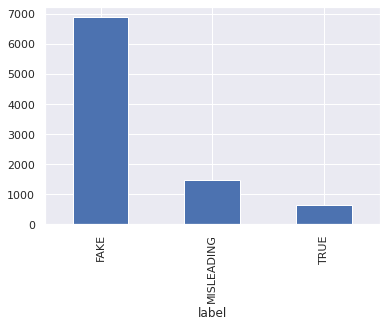

In [ ]:
target = model_data.groupby('label')['label'].count()
target.plot.bar()

In [ ]:
categ_feature_list = list(model_data.columns)

In [ ]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

stop_words = set(stopwords.words('english'))
stemer = PorterStemmer()
def remove_SW_Stem(text):


  text=[stemer.stem(words) for words in text.split(" ") if words not in stop_words]
  return " ".join(text)
special_chars = re.compile('[^a-z]')
add_space = re.compile('[/(){}\[\]\\@;]')
def clean_text(text):

  text=text.lower()
  text = add_space.sub(" ",text)
  text = special_chars.sub(" ",text)
  text = remove_SW_Stem(text)
  return text

for feature in categ_feature_list:
  model_data[feature] = model_data[feature].apply(lambda text:clean_data(text))

NameError: ignored

In [ ]:
data=df
df=df[['title','label']]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9077 entries, 0 to 9076
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   9077 non-null   object
 1   label   9077 non-null   object
dtypes: object(2)
memory usage: 142.0+ KB


In [ ]:
df['token_length'] = [len(x.split(" ")) for x in df.title]
max(df.token_length)

114

In [ ]:
df.loc[df.token_length.idxmax(),'title']

' A WhatsApp forward has gone viral which claimed that a vaccine for coronavirus has been discovered. The viral forward also claims that the treatment for coronavirus is mentioned in India’s Intermediate Zoology book. The viral forward reads, “It is not a new disease as it is already mentioned in the Intermediate zoology book along with its treatment. It happens sometimes that many great scientists and doctors do not focus on lesser-known books as they are mostly busy with famous books. Book name: Zoology, Writer: Dr. Ramesh Gupta, Page No. 1072.) Friends, this is not fake news so I request you to kindly share it maximum so all coronavirus patients are treated in time.”'

In [ ]:
df.label.value_counts()

FAKE           6896
MISLEADING     1464
TRUE            658
Explanatory      59
Name: label, dtype: int64

In [ ]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", 
                   "can't've": "cannot have", "'cause": "because", "could've": "could have", 
                   "couldn't": "could not", "couldn't've": "could not have","didn't": "did not", 
                   "doesn't": "does not", "don't": "do not", "hadn't": "had not", 
                   "hadn't've": "had not have", "hasn't": "has not", "haven't": "have not", 
                   "he'd": "he would", "he'd've": "he would have", "he'll": "he will", 
                   "he'll've": "he will have", "he's": "he is", "how'd": "how did", 
                   "how'd'y": "how do you", "how'll": "how will", "how's": "how is", 
                   "I'd": "I would", "I'd've": "I would have", "I'll": "I will", 
                   "I'll've": "I will have","I'm": "I am", "I've": "I have", 
                   "i'd": "i would", "i'd've": "i would have", "i'll": "i will", 
                   "i'll've": "i will have","i'm": "i am", "i've": "i have", 
                   "isn't": "is not", "it'd": "it would", "it'd've": "it would have", 
                   "it'll": "it will", "it'll've": "it will have","it's": "it is", 
                   "let's": "let us", "ma'am": "madam", "mayn't": "may not", 
                   "might've": "might have","mightn't": "might not","mightn't've": "might not have", 
                   "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", 
                   "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", 
                   "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not",
                   "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", 
                   "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", 
                   "she's": "she is", "should've": "should have", "shouldn't": "should not", 
                   "shouldn't've": "should not have", "so've": "so have","so's": "so as", 
                   "this's": "this is",
                   "that'd": "that would", "that'd've": "that would have","that's": "that is", 
                   "there'd": "there would", "there'd've": "there would have","there's": "there is", 
                       "here's": "here is",
                   "they'd": "they would", "they'd've": "they would have", "they'll": "they will", 
                   "they'll've": "they will have", "they're": "they are", "they've": "they have", 
                   "to've": "to have", "wasn't": "was not", "we'd": "we would", 
                   "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", 
                   "we're": "we are", "we've": "we have", "weren't": "were not", 
                   "what'll": "what will", "what'll've": "what will have", "what're": "what are", 
                   "what's": "what is", "what've": "what have", "when's": "when is", 
                   "when've": "when have", "where'd": "where did", "where's": "where is", 
                   "where've": "where have", "who'll": "who will", "who'll've": "who will have", 
                   "who's": "who is", "who've": "who have", "why's": "why is", 
                   "why've": "why have", "will've": "will have", "won't": "will not", 
                   "won't've": "will not have", "would've": "would have", "wouldn't": "would not", 
                   "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would",
                   "y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                   "you'd": "you would", "you'd've": "you would have", "you'll": "you will", 
                   "you'll've": "you will have", "you're": "you are", "you've": "you have" } 

In [ ]:
import codecs
import unidecode
import re
import spacy
nlp = spacy.load('en')

def spacy_cleaner(text):
    try:
        decoded = unidecode.unidecode(codecs.decode(text, 'unicode_escape'))
    except:
        decoded = unidecode.unidecode(text)
    apostrophe_handled = re.sub("’", "'", decoded)
    expanded = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in apostrophe_handled.split(" ")])
    parsed = nlp(expanded)
    final_tokens = []
    for t in parsed:
        if t.is_punct or t.is_space or t.like_num or t.like_url or str(t).startswith('@'):
            pass
        else:
            if t.lemma_ == '-PRON-':
                final_tokens.append(str(t))
            else:
                sc_removed = re.sub("[^a-zA-Z]", '', str(t.lemma_))
                if len(sc_removed) > 1:
                    final_tokens.append(sc_removed)
    joined = ' '.join(final_tokens)
    spell_corrected = re.sub(r'(.)\1+', r'\1\1', joined)
    return spell_corrected

In [ ]:
!pip install Unidecode

     |████████████████████████████████| 245kB 4.3MB/s 


In [ ]:
pd.set_option('display.max_colwidth', -1)
df.title[:10]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning:

Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.



0     If you can hold your breath for 10 seconds then you don’t have fibrosis and therefore no infection. Picture of text in English describing the method.                                                                                                                                          
1     The movie Venom predicted the epidemic.                                                                                                                                                                                                                                                        
2     A political assistant did not ask media outlets to defame Brazilian President Jair Bolsonaro.                                                                                                                                                                                                  
3     This is Dr. Li-wen Liang’s funeral ceremony.                                                                    

In [ ]:
df['clean_text'] = [spacy_cleaner(t) for t in df.title]

In [ ]:

from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer

tvec = TfidfVectorizer(stop_words=None, max_features=100000, ngram_range=(1, 4))
lr = LogisticRegression()

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score, recall_score, f1_score

def lr_cv(splits, X, Y, pipeline, average_method):
    
    kfold = StratifiedKFold(n_splits=splits, shuffle=True, random_state=777)
    accuracy = []
    precision = []
    recall = []
    f1 = []
    for train, test in kfold.split(X, Y):
        lr_fit = pipeline.fit(X[train], Y[train])
        prediction = lr_fit.predict(X[test])
        scores = lr_fit.score(X[test],Y[test])
        
        accuracy.append(scores * 100)
        precision.append(precision_score(Y[test], prediction, average=average_method)*100)
    
        print('              FAKE    MISLEADING     TRUE     Explanatory')
        print('precision:',precision_score(Y[test], prediction, average=None))
        recall.append(recall_score(Y[test], prediction, average=average_method)*100)
        print('recall:   ',recall_score(Y[test], prediction, average=None))
        f1.append(f1_score(Y[test], prediction, average=average_method)*100)
        print('f1 score: ',f1_score(Y[test], prediction, average=None))
        print('-'*50)

    print("accuracy: %.2f%% (+/- %.2f%%)" % (np.mean(accuracy), np.std(accuracy)))
    print("precision: %.2f%% (+/- %.2f%%)" % (np.mean(precision), np.std(precision)))
    print("recall: %.2f%% (+/- %.2f%%)" % (np.mean(recall), np.std(recall)))
    print("f1 score: %.2f%% (+/- %.2f%%)" % (np.mean(f1), np.std(f1)))


In [ ]:
from sklearn.pipeline import Pipeline
original_pipeline = Pipeline([
    ('vectorizer', tvec),
    ('classifier', lr)
])
lr_cv(5, df.clean_text, df.label, original_pipeline, 'macro')

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



              FAKE    MISLEADING     TRUE     Explanatory
precision: [0.         0.7859589  0.83333333 0.97826087]
recall:    [0.         0.99782609 0.05136986 0.34090909]
f1 score:  [0.         0.87931034 0.09677419 0.50561798]
--------------------------------------------------


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



              FAKE    MISLEADING     TRUE     Explanatory
precision: [0.         0.78538813 0.88888889 0.96363636]
recall:    [0.         0.99782451 0.02730375 0.40151515]
f1 score:  [0.         0.87895241 0.05298013 0.56684492]
--------------------------------------------------


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



              FAKE    MISLEADING     TRUE     Explanatory
precision: [0.         0.77891156 0.72222222 0.93939394]
recall:    [0.         0.99637418 0.0443686  0.23484848]
f1 score:  [0.         0.87432389 0.08360129 0.37575758]
--------------------------------------------------


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



              FAKE    MISLEADING     TRUE     Explanatory
precision: [0.         0.78502001 0.77777778 0.9375    ]
recall:    [0.         0.99564902 0.04778157 0.34351145]
f1 score:  [0.         0.87787724 0.09003215 0.5027933 ]
--------------------------------------------------
              FAKE    MISLEADING     TRUE     Explanatory
precision: [0.         0.78932262 0.94117647 0.92857143]
recall:    [0.         0.99709935 0.05460751 0.39694656]
f1 score:  [0.         0.88112784 0.10322581 0.55614973]
--------------------------------------------------
accuracy: 78.96% (+/- 0.46%)
precision: 64.18% (+/- 2.09%)
recall: 34.64% (+/- 1.49%)
f1 score: 36.63% (+/- 1.75%)


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [ ]:
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import ADASYN, SMOTE, RandomOverSampler
ROS_pipeline = make_pipeline(tvec, RandomOverSampler(random_state=777),lr)
SMOTE_pipeline = make_pipeline(tvec, SMOTE(random_state=777),lr)


/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning:

The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning:

The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.



In [ ]:
lenx=int(len(df['title'])*.8)

testing_text=df['title'][lenx:]
testing_target=df['label'][lenx:]

In [ ]:
tv = TfidfVectorizer(stop_words=None, max_features=100000)
testing_tfidf = tv.fit_transform(testing_text)
ros = RandomOverSampler(random_state=777)
X_ROS, y_ROS = ros.fit_sample(testing_tfidf, testing_target)
pd.DataFrame(testing_tfidf.todense(), columns=tv.get_feature_names())

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.



00  000   10  100  1000  100b  100km  106  1072   11  116   12  122gb  \
0     0.0  0.0  0.0  0.0  0.0   0.0   0.0    0.0  0.0   0.0  0.0  0.0  0.0     
1     0.0  0.0  0.0  0.0  0.0   0.0   0.0    0.0  0.0   0.0  0.0  0.0  0.0     
2     0.0  0.0  0.0  0.0  0.0   0.0   0.0    0.0  0.0   0.0  0.0  0.0  0.0     
3     0.0  0.0  0.0  0.0  0.0   0.0   0.0    0.0  0.0   0.0  0.0  0.0  0.0     
4     0.0  0.0  0.0  0.0  0.0   0.0   0.0    0.0  0.0   0.0  0.0  0.0  0.0     
...   ...  ...  ...  ...  ...   ...   ...    ...  ...   ...  ...  ...  ...     
1811  0.0  0.0  0.0  0.0  0.0   0.0   0.0    0.0  0.0   0.0  0.0  0.0  0.0     
1812  0.0  0.0  0.0  0.0  0.0   0.0   0.0    0.0  0.0   0.0  0.0  0.0  0.0     
1813  0.0  0.0  0.0  0.0  0.0   0.0   0.0    0.0  0.0   0.0  0.0  0.0  0.0     
1814  0.0  0.0  0.0  0.0  0.0   0.0   0.0    0.0  0.0   0.0  0.0  0.0  0.0     
1815  0.0  0.0  0.0  0.0  0.0   0.0   0.0    0.0  0.0   0.0  0.0  0.0  0.0     

       13  130  134  135   14   15  1551  15th   16  165   17  1720   18  182  \
0     0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0   0.0  0.0  0.0  0.0   0.0  0.0   
1     0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0   0.0  0.0  0.0  0.0   0.0  0.0   
2     0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0   0.0  0.0  0.0  0.0   0.0  0.0   
3     0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0   0.0  0.0  0.0  0.0   0.0  0.0   
4     0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0   0.0  0.0  0.0  0.0   0.0  0.0   
...   ...  ...  ...  ...  ...  ...  ...   ...   ...  ...  ...  ...   ...  ...   
1811  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0   0.0  0.0  0.0  0.0   0.0  0.0   
1812  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0   0.0  0.0  0.0  0.0   0.0  0.0   
1813  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0   0.0  0.0  0.0  0.0   0.0  0.0   
1814  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0   0.0  0.0  0.0  0.0   0.0  0.0   
1815  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0   0.0  0.0  0.0  0.0   0.0  0.0   

      1869        19  1919  1988  1990s  1st   20  200  2000  2001  2003  \
0     0.0   0.000000  0.0   0.0   0.0    0.0  0.0  0.0  0.0   0.0   0.0    
1     0.0   0.116862  0.0   0.0   0.0    0.0  0.0  0.0  0.0   0.0   0.0    
2     0.0   0.000000  0.0   0.0   0.0    0.0  0.0  0.0  0.0   0.0   0.0    
3     0.0   0.000000  0.0   0.0   0.0    0.0  0.0  0.0  0.0   0.0   0.0    
4     0.0   0.118796  0.0   0.0   0.0    0.0  0.0  0.0  0.0   0.0   0.0    
...   ...        ...  ...   ...   ...    ...  ...  ...  ...   ...   ...    
1811  0.0   0.000000  0.0   0.0   0.0    0.0  0.0  0.0  0.0   0.0   0.0    
1812  0.0   0.000000  0.0   0.0   0.0    0.0  0.0  0.0  0.0   0.0   0.0    
1813  0.0   0.000000  0.0   0.0   0.0    0.0  0.0  0.0  0.0   0.0   0.0    
1814  0.0   0.000000  0.0   0.0   0.0    0.0  0.0  0.0  0.0   0.0   0.0    
1815  0.0   0.000000  0.0   0.0   0.0    0.0  0.0  0.0  0.0   0.0   0.0    

      2004  2005  201  2010  2011  2012  2014  2015  2017  2018  2019  2019n  \
0     0.0   0.0   0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0     
1     0.0   0.0   0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0     
2     0.0   0.0   0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0     
3     0.0   0.0   0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0     
4     0.0   0.0   0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0     
...   ...   ...   ...  ...   ...   ...   ...   ...   ...   ...   ...   ...     
1811  0.0   0.0   0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0     
1812  0.0   0.0   0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0     
1813  0.0   0.0   0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0     
1814  0.0   0.0   0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0     
1815  0.0   0.0   0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0     

      2020  2021  2022  2027  20th   21  2144   22  220  223   23  232   24  \
0     0.0   0.0   0.0   0.0   0.0   0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0   
1     0.0   0.0   0.0   0.0   0.0   0.0  

In [ ]:
lr_cv(5, df.title, df.label, ROS_pipeline, 'macro')

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



              FAKE    MISLEADING     TRUE     Explanatory
precision: [0.55       0.84968685 0.39655172 0.69291339]
recall:    [0.91666667 0.88478261 0.31506849 0.66666667]
f1 score:  [0.6875     0.86687966 0.35114504 0.67953668]
--------------------------------------------------


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



              FAKE    MISLEADING     TRUE     Explanatory
precision: [0.625      0.85605536 0.46551724 0.70731707]
recall:    [0.83333333 0.89702683 0.36860068 0.65909091]
f1 score:  [0.71428571 0.87606232 0.41142857 0.68235294]
--------------------------------------------------


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



              FAKE    MISLEADING     TRUE     Explanatory
precision: [0.46153846 0.85245902 0.37728938 0.6031746 ]
recall:    [0.54545455 0.86729514 0.35153584 0.57575758]
f1 score:  [0.5        0.85981308 0.3639576  0.58914729]
--------------------------------------------------


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



              FAKE    MISLEADING     TRUE     Explanatory
precision: [0.53846154 0.85724234 0.45147679 0.68992248]
recall:    [0.58333333 0.89267585 0.36518771 0.67938931]
f1 score:  [0.56       0.87460036 0.40377358 0.68461538]
--------------------------------------------------


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



              FAKE    MISLEADING     TRUE     Explanatory
precision: [0.5        0.85097493 0.42738589 0.74590164]
recall:    [0.66666667 0.88614938 0.35153584 0.69465649]
f1 score:  [0.57142857 0.86820604 0.38576779 0.71936759]
--------------------------------------------------
accuracy: 78.14% (+/- 1.17%)
precision: 62.49% (+/- 2.92%)
recall: 65.00% (+/- 4.07%)
f1 score: 63.25% (+/- 3.05%)


In [ ]:
smt = SMOTE(random_state=777, k_neighbors=1)
X_SMOTE, y_SMOTE = smt.fit_sample(testing_tfidf, testing_target)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.



In [ ]:
lr_cv(5, df.clean_text, df.label, SMOTE_pipeline, 'macro')

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



              FAKE    MISLEADING     TRUE     Explanatory
precision: [0.5        0.85       0.38132296 0.72649573]
recall:    [0.91666667 0.87463768 0.33561644 0.64393939]
f1 score:  [0.64705882 0.86214286 0.35701275 0.68273092]
--------------------------------------------------


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



              FAKE    MISLEADING     TRUE     Explanatory
precision: [0.625      0.85557084 0.46696035 0.7394958 ]
recall:    [0.83333333 0.90210297 0.36177474 0.66666667]
f1 score:  [0.71428571 0.87822097 0.40769231 0.70119522]
--------------------------------------------------


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



              FAKE    MISLEADING     TRUE     Explanatory
precision: [0.46153846 0.84308131 0.36585366 0.61061947]
recall:    [0.54545455 0.85714286 0.35836177 0.52272727]
f1 score:  [0.5        0.85005394 0.36206897 0.56326531]
--------------------------------------------------


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



              FAKE    MISLEADING     TRUE     Explanatory
precision: [0.58333333 0.85795053 0.44827586 0.68503937]
recall:    [0.58333333 0.88034808 0.39931741 0.66412214]
f1 score:  [0.58333333 0.86900501 0.42238267 0.6744186 ]
--------------------------------------------------


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



              FAKE    MISLEADING     TRUE     Explanatory
precision: [0.5        0.84844193 0.40304183 0.7016129 ]
recall:    [0.66666667 0.86874547 0.36177474 0.66412214]
f1 score:  [0.57142857 0.85847367 0.38129496 0.68235294]
--------------------------------------------------
accuracy: 77.50% (+/- 1.57%)
precision: 62.27% (+/- 3.39%)
recall: 64.53% (+/- 4.49%)
f1 score: 62.84% (+/- 3.44%)
